In [18]:
# !pip install -U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
# !pip install --upgrade git+https://github.com/huggingface/transformers.git

**Relevant huggingface gpt2 code**

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py
- https://github.com/huggingface/transformers/issues/6535
- bos/eos discussion: https://github.com/huggingface/transformers/issues/3311

**Todo**

- Rerun embedding generation for musiccaps/make sure it's the same as jamendo and none of the changes in mtg_jam.. broke it (forward hook should use input or output correctly)
- embedding concat vs sum vs mean
- metrics (with different generation methods/args)
- tokenization might still be a problem

# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np
from rich import print as printr
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import itertools
import math
from rich import print as printr
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import json
import random
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def filter_muscaps_with_embeddings(ds, embeddings):
    '''Some clips weren't downloaded so we couldn't embed them, get rid of that'''
    exclude_ids = set()
    for i in range(len(ds)):
        if ds[i]['ytid'] not in embeddings.keys():
            exclude_ids.add(i)
    ds = ds.select(
        (
            i for i in range(len(ds)) 
            if i not in set(exclude_ids)
        )
    )
    assert len(ds) == len(embeddings)
    return ds

In [3]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
class CaptionEmbedding(Dataset):
    '''Returns a torch Dataset of paired captions and embeddings'''
    def __init__(self, muscaps_ds, embeddings):
        ds = filter_muscaps_with_embeddings(muscaps_ds, embeddings)
        self.captions = ds.sort(column='ytid')['caption']
        sorted_embs = [value for _, value in sorted(embeddings.items())]
        self.embeddings = torch.from_numpy(np.stack(sorted_embs)).to(device)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        
        emb = self.embeddings[idx]
        assert len(emb) == 512
        emb = (emb[:256]+emb[256:])/2
        
        return self.captions[idx], emb

In [5]:
dataset = CaptionEmbedding(muscaps_ds=ds, embeddings=embeddings)
train_frac = 0.8
training_data, test_data = random_split(dataset, [train_frac, 1-train_frac])

# quick check did not mess up ordering of caption-embedding pairs
# for cap, emb in tqdm(dataset):
#     for i in range(len(ds)):
#         if cap == ds[i]['caption']:
#             assert torch.allclose(emb,torch.from_numpy(embeddings[ds[i]['ytid']]).to(device))

Parameter 'indices'=<generator object filter_muscaps_with_embeddings.<locals>.<genexpr> at 0x7fc66e4bf580> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
# get a list of music-related words to use for evaluation
aspects = []
for x in ds:
    aspect_str = x['aspect_list']
    for t in ('[]"\''):
        aspect_str = aspect_str.replace(t, '')
    aspects.extend(aspect_str.split(', '))
    
from collections import Counter
# only pick aspects that show up somewhat frequently
aspects = {s for s, count in Counter(aspects).most_common() if count >= 25}
len(aspects)

378

# Load Jamendo tag/embedding dataset

In [7]:
JAMENDO_TAGS = np.array(['genre---alternative','genre---ambient','genre---atmospheric','genre---chillout','genre---classical','genre---dance','genre---downtempo','genre---easylistening','genre---electronic','genre---experimental','genre---folk','genre---funk','genre---hiphop','genre---house','genre---indie','genre---instrumentalpop','genre---jazz','genre---lounge','genre---metal','genre---newage','genre---orchestral','genre---pop','genre---popfolk','genre---poprock','genre---reggae','genre---rock','genre---soundtrack','genre---techno','genre---trance','genre---triphop','genre---world','instrument---acousticguitar','instrument---bass','instrument---computer','instrument---drummachine','instrument---drums','instrument---electricguitar','instrument---electricpiano','instrument---guitar','instrument---keyboard','instrument---piano','instrument---strings','instrument---synthesizer','instrument---violin','instrument---voice','mood/theme---emotional','mood/theme---energetic','mood/theme---film','mood/theme---happy','mood/theme---relaxing'])

def get_top_tags(scores, k=3, threshold=.4):
    assert scores.shape == (2, 50)
    scores = (scores[0]+scores[1])/2
    indices = np.where(scores>threshold)[0]
    sorted_indices = indices[np.argsort(-scores[indices])[:k]]
    return JAMENDO_TAGS[sorted_indices]

In [8]:
jam_tags = {}
jam_pred_tags = {}
jam_embeddings = {}
jam_scores = {}

jam_embeddings_dir = Path('./jam_embeddings')

for i in range(100):
    try:
        with open(jam_embeddings_dir / f'tags_{i:02d}.json') as f:
            jam_tags.update(json.load(f))
    except Exception as e:
        print(e)
        continue
    data_dict = np.load(jam_embeddings_dir / f'embeddings_{i:02d}.npy', allow_pickle=True)
    jam_embeddings.update(data_dict.item())
    data_dict = np.load(jam_embeddings_dir / f'tag_scores_{i:02d}.npy', allow_pickle=True)
    jam_scores.update(data_dict.item())
    
for k, v in jam_scores.items():
    jam_pred_tags[k] = get_top_tags(v, k=3, threshold=0.4)
    
pred_tag_counts = np.array([len(v) for v in jam_pred_tags.values()])
print(f'avg number of pred tags = {(pred_tag_counts).mean()}, fraction of samples with 0 pred tags = {(pred_tag_counts==0).mean()}')

[Errno 2] No such file or directory: 'jam_embeddings/tags_35.json'
avg number of pred tags = 1.1215934627170583, fraction of samples with 0 pred tags = 0.21151453245426688


In [9]:
pred_tag_counts = np.array([len(v) for v in jam_tags.values()])
print(f'avg number of jamendo tags = {(pred_tag_counts).mean()}, fraction of samples with 0 jamendo tags = {(pred_tag_counts==0).mean()}')

avg number of jamendo tags = 4.659095552047543, fraction of samples with 0 jamendo tags = 0.0


In [10]:
for x in list(jam_tags.keys())[:15]:
    print(jam_tags[x])
    print(jam_pred_tags[x])
    print()

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock' 'instrument---drums']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock' 'instrument---drums' 'instrument---bass']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---electronic']
['genre---electronic' 'genre---dance']

['genre---electronic']
['genre---electronic']

In [11]:
class JamendoTagDataset(Dataset):
    def __init__(self, jam_tags, jam_pred_tags, jam_embeddings):
        
        self.keys = sorted(jam_tags.keys())
        self.jam_tags = jam_tags
        self.jam_pred_tags = jam_pred_tags
        self.jam_embeddings = jam_embeddings

    def __len__(self):
        return len(self.jam_tags)

    def __getitem__(self, idx):
        id = self.keys[idx]
        
        tags = self.jam_tags[id]
        categories = defaultdict(set)
        for t in tags:
            assert '---' in t
            categories[t[:t.find('---')]].add(t[t.find('---')+3:])
            
        result = []
        for k in sorted(categories.keys()):
            cat_tags = list(categories[k])
            result.append(k + ': ' + ', '.join(random.sample(cat_tags, len(cat_tags))))
        tags_cap = '; '.join(result)
            
        #tags = [t.replace('---', ': ') for t in tags]
        #tags = [t[t.find('---')+3:] if '---' in t else t for t in tags]
        #random.shuffle(tags)
        #tags_cap = ', '.join(tags)
        
        emb = self.jam_embeddings[id]
        assert emb.shape == (2, 256)
        emb = (emb[0]+emb[1])/2
        
        return tags_cap, torch.from_numpy(emb).to(device)

In [12]:
jam_dataset = JamendoTagDataset(jam_tags, jam_pred_tags, jam_embeddings)
train_frac = 0.8
training_data, test_data = random_split(jam_dataset, [train_frac, 1-train_frac])

# Training

### Tokenization

target should be:

`"<pad> caption <eos> <mask...>"` (first element is dropped in transformer.forward)

input should be:

`"<music-emb> caption <eos> <pad...>"`

where

- `<bos>` = `<eos>` (for gpt2, see https://github.com/huggingface/transformers/issues/2026)
- `<mask>` is -100 (masked in cross-entropy, see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- `<pad>` is arbitrary
- `<music-emb>` is the encoded music

In [13]:
class ResidualLinear(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        
    def forward(self, x):
        return x + self.fc(torch.nn.functional.relu(x))

class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(256, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
        )
        
    def forward(self, x):
        return self.main(x)

In [15]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)['input_ids']
    
     # wrap in eos and add placeholder for music embedding/mask
    input_ids = [torch.tensor([placeholder_id] + x + [eos_id]) for x in input_ids]
    # pad with -100, this index is masked in the cross-entropy loss
    input_ids_target = torch.nn.utils.rnn.pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=mask_id
    ).to(device)
    
    # index -100 isn't valid as model input however, since the token embedding lookup fails
    # so we need a second version as model input, with -100 replaced with another token (shouldn't matter which)
    input_ids = input_ids_target.clone()
    input_ids[input_ids==mask_id] = eos_id
    
    return input_ids, input_ids_target

In [16]:
def transform_input_ids(music_embedding, input_ids, input_ids_target):
    music_emb_ind = 0
    assert (input_ids[:, music_emb_ind]==placeholder_id).all()
    assert (input_ids_target[:, music_emb_ind]==placeholder_id).all()

    input_ids_target[:, music_emb_ind] = mask_id
    input_ids[:, music_emb_ind] = eos_id # temp placeholder to make the embedding lookup work
    inputs_embeds = model.transformer.wte(input_ids)
    
    inputs_embeds[:, music_emb_ind] = b2t(music_embedding)
    
    return inputs_embeds, input_ids_target

In [17]:
@torch.no_grad()
def manual_generate_single(inputs_embeds, max_length, do_sample):
    """ Autoregressively generate max_len tokens based on the embedded prompt. """
    result = []
    log_probs = []

    for i in range(max_length):
        logits = model.forward(inputs_embeds=inputs_embeds).logits[:, -1]

        distr = torch.distributions.Categorical(logits=logits)
        token_inds = distr.sample() if do_sample else logits.argmax(-1)
        log_probs.append(distr.log_prob(token_inds))
        
        result.append(token_inds)

        inputs_embeds = torch.cat([
            inputs_embeds,
            model.transformer.wte(token_inds).unsqueeze(1)
        ], dim=1)
        
    log_probs = torch.stack(log_probs, dim=1)
    ppl = 2**(-(1/len(log_probs))*log_probs.sum(-1))
        
    return torch.stack(result, dim=1), ppl

@torch.no_grad()
def manual_generate(inputs_embeds, iters, max_length, do_sample):
    """ Repeatedly generate samples using manual_generate_single and return the ones with the lowest perplexity. """
    preds = []
    ppls = []
    
    for i in range(iters):
        pred, ppl = manual_generate_single(inputs_embeds, max_length, do_sample)
        preds.append(pred)
        ppls.append(ppl)
    
    preds = torch.stack(preds)
    ppls = torch.stack(ppls)
    
    max_ppl_inds = ppls.argmin(0)
    best_preds = preds[max_ppl_inds, np.arange(preds.shape[1])]
    
    return best_preds, ppls.min(0)[0]

In [18]:
def eval(caption_batch, embedding_batch, use_manual_generation=False, **kwargs):
    model.eval()
    input_ids, input_ids_target = tokenize(caption_batch)
    inputs_embeds, input_ids_target = transform_input_ids(
        embedding_batch,
        input_ids,
        input_ids_target
    )
    
    if use_manual_generation:
        output_ids, ppl = manual_generate(inputs_embeds, **kwargs)
    else:
        output_ids = model.generate(inputs_embeds=inputs_embeds, **kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    
    pred = [p.replace('\n', '').strip() for p in pred]
    return pred

In [24]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
b2t = B2T().cuda()

mask_id = -100 # don't change, this is fixed in torch cross-entropy loss!
eos_id = tokenizer.eos_token_id
# bos_id = eos_id
placeholder_id = -200

opt = torch.optim.Adam([
    {'params': b2t.parameters(), 'lr': 0.0001},
    # disable AdamW weight decay for gpt2 layer finetuning!
    #{'params': model.parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[1].parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[2].parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[3].parameters(), 'lr': 0, 'weight_decay': 0},
])

batch_size = 32
num_epochs = 5000

losses = []
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_test_dataloader = DataLoader(test_data, 1, shuffle=True)

todo:
- maybe use bos token at beginning and use attention_mask to mask out hidden states from the very first generated token? but: generate doesn't use attention_mask, which is weird? instead it has a pad_token_id/mask_token_id though? 

In [25]:
generation_params_hf = dict(
    max_length=64,
    num_beams=4,
    do_sample=True,
    temperature=1,
    pad_token_id=mask_id,
    use_manual_generation=False
)

generation_params_ours = dict(
    max_length=64,
    iters=4,
    do_sample=True,
    use_manual_generation=True
)

In [26]:
def update_step(inputs_embeds, input_ids_target):
    model.train()
    loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
    loss.backward()
    opt.step()
    return loss.item()

def eval_step():
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params_hf)
    printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
    printr('[blue]TRAIN PRED-HF: ' + pred[0])
    pred = eval(caption_batch, embedding_batch, **generation_params_ours)
    printr('[blue]TRAIN PRED-OUR: ' + pred[0])

    caption_batch, embedding_batch = next(iter(eval_test_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params_hf)
    printr('[green bold]TEST TRUE: ' + caption_batch[0])
    printr('[blue]TEST PRED-HF: ' + pred[0])
    pred = eval(caption_batch, embedding_batch, **generation_params_ours)
    printr('[blue]TEST PRED-OUR: ' + pred[0])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/6731 [00:00<?, ?it/s]

TRAIN TRUE: genre: jazz

TRAIN PRED-HF: <|endoftext|>The UESPWiki – Your source for The Elder Scrolls since 1995This page is currently being
rewritten as part of the Morrowind Overhaul Project.The page is being rewritten and checked in several stages. All 
users are welcome to make changes to the page. If you make a change that is

TRAIN PRED-OUR: In a move that could have guaranteed the lopsided win that ultimately rippled out in LA, the Los 
Angeles Metropolitan Transportation Authority has created a hitchroad for it.The district, implementing a system 
announced Friday night, carries pedestrian and towing duties along Ayr in downtown Los Angeles.The

TEST TRUE: genre: electronic, hardrock, metal, pop; mood/theme: zen, planant

TEST PRED-HF: <|endoftext|>The New York Times reports that President Donald Trump's campaign manager, Kellyanne 
Conway, is being investigated by the FBI as part of a probe into possible collusion between the Trump campaign and 
Russia.The Times reports that Trump's campaign manager, Kellyanne Conway, is being investigated by the FBI as part

TEST PRED-OUR: Blotter welcomes endorsement of http://en.matsgrabatix.com/ reformAfter weeks of pro bono efforts, 
Senate Majority Leader Harry Reid on Wednesday announced he will not sign legislation banning the contraception 
mandate.Sen. Harry Reid (D-Nev.) read a letter from Women's

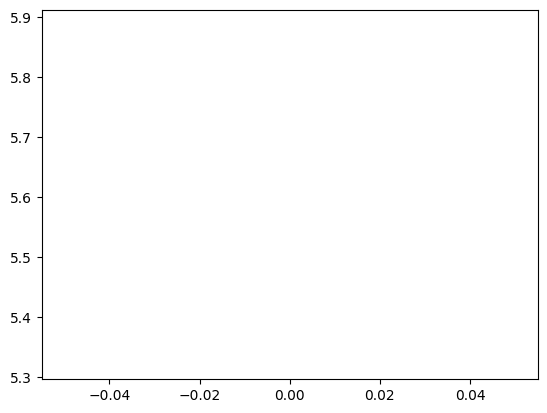

TRAIN TRUE: genre: ambient, electronic, electronica

TRAIN PRED-HF: <|endoftext|>I've always been a fan of the old-school punk rockers of the '70s and '80s, but I've 
never really been a fan of the indie rockers of the '90s or '00s, either. I've never really been a fan of any of 
the bands that I

TRAIN PRED-OUR: Admiral Master Showlist:Listen to Admiral Music 2015Richard Meyers' cc: 5303 Sat Oct 10 04:07 pm 
01:06 pm Empire Act 12: This Time Has Tamarell [12:58:17]Vendor Music: Torture Didget

TEST TRUE: genre: choir, orchestral, soundtrack; mood/theme: epic, film

TEST PRED-HF: <|endoftext|>This article is from the archive of our partner.This is the second installment in a 
series of articles on the state of the U.S. economy. The first installment is based on data from the Bureau of 
Labor Statistics. The second installment is based on data from the Bureau of Labor Statistics.

TEST PRED-OUR: VOL. 278: [Comments] Hermisi Gaudi principale Amts - die Deutschen Grundstkammefisch USA 1978 
[1]Salam Fechstein minret aus Buchmirmjäger Subolitionzeug - Vert Kraffbuch 1970 su

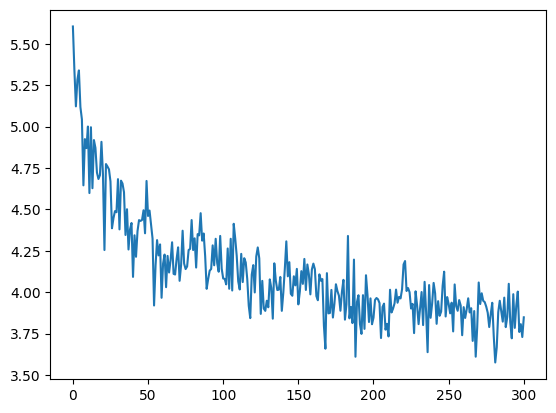

TRAIN TRUE: genre: electronic, house, acidhouse

TRAIN PRED-HF: <|endoftext|>There's been a lot of speculation about the future of the NBA over the last couple of 
months, but this is the first time we've heard anything about it.It's been a while since we've heard anything about
it, so let's get down to it.The NBA has always been

TRAIN PRED-OUR: 6'34 hall picking Habanos, when The Screen Guide recommends them in semifinals (byRein-Carter, NY 
Times, Ten1)Officers Dallas Kelley's (Bay Games business) 8 sided pick 49ers at eternal home field (1999) on left 
side of tank with 14 Eagles ruled Kam

TEST TRUE: genre: electronic, trance, techno; instrument: synthesizer, piano; mood/theme: party, happy

TEST PRED-HF: <|endoftext|>This is a blog post that I wrote about a couple of years ago. It's been a while since 
I've written a blog post, so I thought I'd share it with you.This post is based on a post I wrote a while ago. I 
think it's pretty good, but it's

TEST PRED-OUR: Abstract To date this has been widely accepted and represented the premiere manic with insufficiency
of any sharp response as index of attention or seeking–priater preference), rather than as a destiny hazard 
(Collegegate 1991; Fenton et al. 2009; Snakenetian and Deener 2010). We selected 120 rat samples

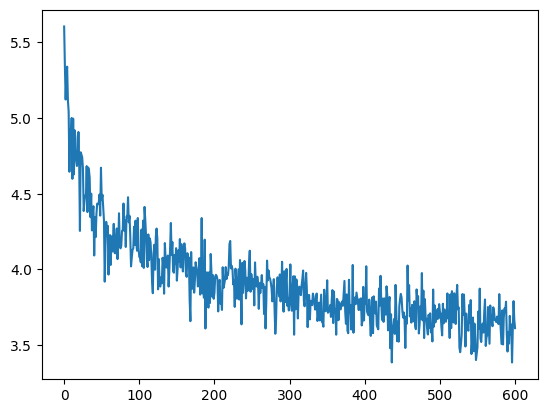

TRAIN TRUE: genre: experimental; instrument: synthesizer; mood/theme: dark, slow

TRAIN PRED-HF: <|endoftext|>The U.S. military has deployed more than 3,000 troops in Afghanistan since 2009 to 
fight the Taliban insurgency.The U.S. military has deployed more than 3,000 troops in Afghanistan since 2009 to 
fight the Taliban insurgency.The U.S. military has deployed more than 3

TRAIN PRED-OUR: At Rioportiti chiterarry cares about the environment. So does his hedgehog buddy, Nick Carbonosky, 
a researcher at Seattle-based tourism firm SurePay searches for easy food sellers in his neighborhood, even whether
he'll captivate mosquito pests or koi in a tree bank game. They take a

TEST TRUE: genre: newage, ambient; mood/theme: night, meditative, epic

TEST PRED-HF: <|endoftext|>We're excited to announce the official release of our new Kickstarter project, the first
of its kind.We're excited to announce the official release of our new Kickstarter project, the first of its 
kind.We're excited to announce the official release of our new Kickstarter project, the first of its kind

TEST PRED-OUR: There are versions of this plugin relevant:Download and use the ZIP version:chooser/stuffab1.zipor 
just download and use theme Factory together with your plugin:Credits:<|endoftext|>Best voting factors: Slingshot, 
pro-gnb /bent_republic,

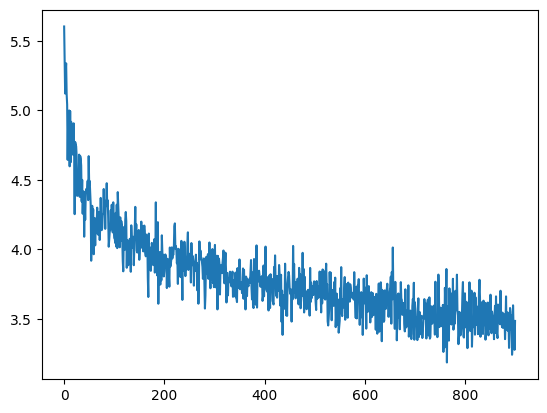

TRAIN TRUE: genre: soundtrack, downtempo, folk; instrument: drummachine, synthesizer, harmonica, electricguitar, 
guitar, bass, acousticguitar, drums; mood/theme: dark

TRAIN PRED-HF: <|endoftext|>Image copyright Getty Images Image caption The BBC's Nick Robinson said the decision to
leave was "a matter of conscience"The BBC's Nick Robinson has called on the government to take a tougher stance on 
climate change.The BBC's Nick Robinson said the decision to leave was "a matter of conscience".

TRAIN PRED-OUR: Styxewoodcoof series. Not of today's tubet information but elegantly muted styles for this time of 
year.Contains eight sliders, 32 modeled rounded velvety sliders, 9 perfectly executed metallic belt buttons, a lip 
gloss, coolbro, contact body, beautifully striking and breath

TEST TRUE: genre: pop; instrument: piano, synthesizer; mood/theme: background, sentimental, sad

TEST PRED-HF: <|endoftext|>This is a collection of all the instruments I've used in the past. I've used a lot of 
different instruments over the years, but this is the one I've used most often. I've used a lot of different 
instruments over the years, but this is the one I've used most often.

TEST PRED-OUR: Review: The most interesting combination of flavors of both genres as a theme where things suddenly 
turn to things of importance.  This is fast, fast, interesting and surprising.(Nano, skip, harp, piano, marching 
instrument, anime instrument bass)<|endoftext|>Outside the Windtruss: The North Windtr

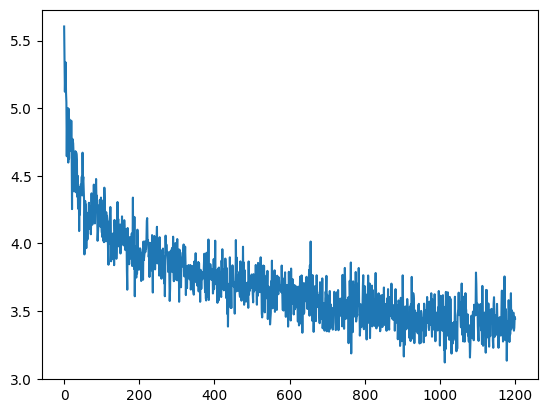

TRAIN TRUE: genre: indie, pop, alternative, rock, experimental; instrument: electricguitar, acousticguitar

TRAIN PRED-HF: <|endoftext|>This is my first attempt at making a decklist. This decklist is based on the decklist I
used in my first decklist.The decklist is based on a decklist that I made in my first decklist.I'm going to try to 
keep it simple. I'm going

TRAIN PRED-OUR: everydaybiz.comA mysterious renewable-electricity generator next to an ancient 
houseWHITEFIELDOWNHeritage Design: Okmiente itto MEOWTHON MITOBOD<|endoftext|>In the Southwestern suburbs of 
Melbourne, the energy use of the electricity truck for mobile agriculture vary little from

TEST TRUE: genre: poprock, folk; mood/theme: slow

TEST PRED-HF: <|endoftext|>This is the first in a series of posts that will examine the history of the music 
industry in the U.S.The music industry in the U.S. has been dominated by the record industry since the mid-1970s. 
It has been dominated by record labels and labels, and it has been

TEST PRED-OUR: Presentation: Afioxidant+. Incubine, properimen; antioxidant-based; pH 7.2.; globulinate and other 
antigens take 5% or less of biological substrate and enhance antioxidant unrefrigerators measurnty recycle off. 
Vetiverinous is polysolute; though

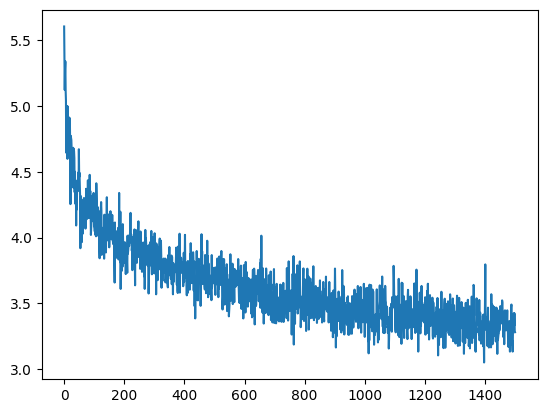

TRAIN TRUE: genre: soul, disco, pop, funk, house; instrument: violin, electricguitar, voice, bongo, conga

TRAIN PRED-HF: <|endoftext|>This was one of the most surprising things I've seen this year. I didn't expect this to
be such a big deal, but I thought it was worth it.It was a lot of fun to play with a bunch of friends. It was a lot
of fun to play with a bunch of people

TRAIN PRED-OUR: September 3, 2018Emily Bolton Concert DownloadBat Ensemble Mixed by Andrea SevediciTheme, set, 
performances, Keys, themes: Williams, Motlen simulation, theme #1 by Charles Monolith Publicist: Andrea GanimThe 
venue is the Weiss Stairs in Allhealth

TEST TRUE: genre: electronic, trance, club; mood/theme: uplifting

TEST PRED-HF: <|endoftext|>AbstractBackground: This study investigated the effects of cannabis use on mood, mood, 
mood-activity, and behavior.Methods: A randomised, double-blind, placebo-controlled, placebo-controlled, 
placebo-controlled, placebo-controlled, placebo-controlled, placebo-controlled, placebo-

TEST PRED-OUR: Extreme atyphesizer, astrometer, astrocissitor; forebrain characteristics: concave atraction, soft 
compared with neutral mask, medium; low sensitivity to light; however, very strong currents: weighty even during 
full investigation, meaning moderate to strong, low sensitivity to light, magnetoadren

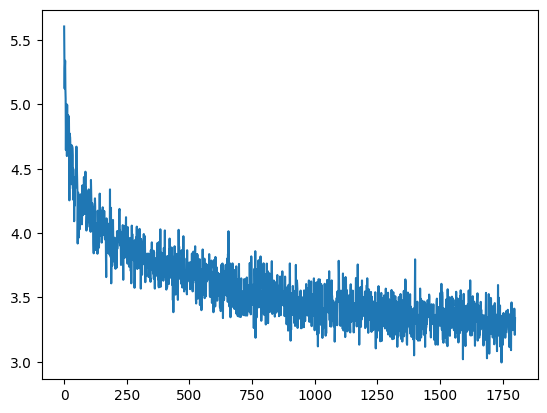

TRAIN TRUE: genre: jazz, latin; instrument: saxophone

TRAIN PRED-HF: <|endoftext|>AbstractImportance: This study examined the association between obesity and diet and 
body weight.Design: Prospective study.Main outcome: Prospective study.Main outcome: Weight, BMI, waist 
circumference, waist-to-hip ratio, waist-to-hip ratio, waist

TRAIN PRED-OUR: From Agent: This homepage is to be presentable by children (and youth), please visit the 
agentsizners.com websiteIf you like Comic's or would like Facebook profile or Feeltheaction website, click these 
heroes or help reduce the zodiac (39 majors DJ cover, 21 artists cover; this is

TEST TRUE: genre: soundtrack; instrument: timpani, viola, cello, trombone, trumpet, cymbal, doublebass, violin, 
tuba, horn; mood/theme: documentary, emotional, film

TEST PRED-HF: <|endoftext|>AbstractBackground: This study examined the effects of smoking and diet on risk of 
cardiovascular disease (CVD). Methods: We examined the association between smoking and the risk of cardiovascular 
disease (CVD) using the Framingham Heart Study, the Nurses' Health Study, the Nurses' Health Study II,

TEST PRED-OUR: Not only is reporting cosmetics nostalgic, it's also kinda cool about their trends as well. Vagina 
trends highlights the pursuit of beauty every single day and includes features of the other favourite, most exotic 
body rub: on the fashion side, gender specific items, casual wear, fashionable wear or more. Similar to lingerie 
and

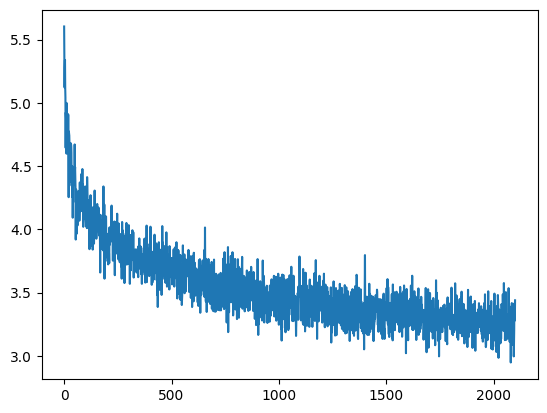

TRAIN TRUE: genre: folk, medieval; mood/theme: motivational, epic, uplifting

TRAIN PRED-HF: <|endoftext|>Image copyright Getty Images Image caption The US president, Vladimir Putin, are 
expected to visit the countryUS President Vladimir Putin has been invited to visit the country, the Kremlin said on
Friday.President Vladimir Putin will visit the country on Friday, the Kremlin said.Mr Putin said the visit was

TRAIN PRED-OUR: Trash: Groundwater: Freshwater: Vegetables 100%: Rock volleyball, 62: Jenchu, bongo ballThe 
Tumbishommedusa will be opening track after practice at 8 p.m. Thursday through Friday<|endoftext|>Media playback: 
NH<|endoftext|>Abstract Suicide rates are present in most siren

TEST TRUE: genre: jazzfunk, jazz; instrument: electricguitar, rhodes, sampler, saxophone, synthesizer, keyboard; 
mood/theme: groovy

TEST PRED-HF: <|endoftext|>This is a list of all the songs to be included in the soundtrack.Tracklist:1. "Siren"2. 
"I'm a Sailor"3. "I'm a Sailor"4. "I'm a Sailor"5. "

TEST PRED-OUR: Making the festival, antelope jingle, swing, scream; drums, drums gangbang, it could be one for the 
memories this weekend<|endoftext|>Just kidding, Chelsea's going barefoot for the weekend. Not classy though. 
Westport branch of the warehouse renovation team here at Sketchshow are supposed to fact check the draft

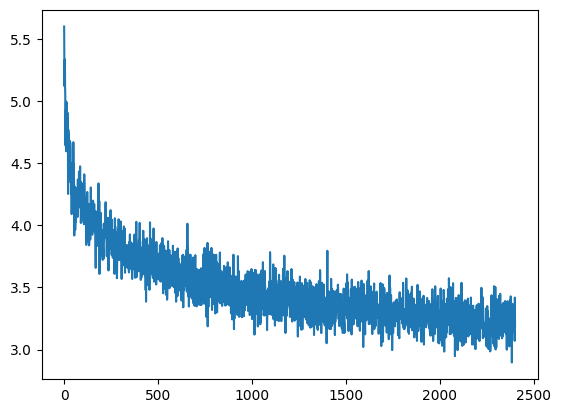

TRAIN TRUE: genre: downtempo, easylistening; instrument: violin

TRAIN PRED-HF: <|endoftext|>Abstract:This study was designed to investigate the effect of sex, age, and gender on 
the risk of prostatectomy, prostatectomy, and prostatectomies. We used a retrospective cohort study to investigate 
the association of sex, age, and risk of prostatectomy, prostatectomy,

TRAIN PRED-OUR: Figure 5: Cleanse gutogen, mucus, sadness, odour, contact; Lilisthes: towels in daycare, lotter, 
fillers, pump, garlic soap, midwipes, syringe, biological drinkFigure 5: Cleanse gutogen, mucus, sadness, odour

TEST TRUE: genre: newage, worldfusion, worldmusik, soundtrack; instrument: bass, saxophone, guitar, voice, 
synthesizer; mood/theme: energetic

TEST PRED-HF: <|endoftext|>AbstractImportance: This study is a prospective cohort study.Design: Prospective 
study.Main outcome: Prospective cohort study.Main outcome: Results: Prospective cohort study.<|endoftext|>

TEST PRED-OUR: Story Change target tracker: →shitfieldDo you use taps every day? Then do you know how often you are
fixly flapping during half of game? Its infitobindangle, idk —energy: hilliersmusickic djerebaninis <younphyson@

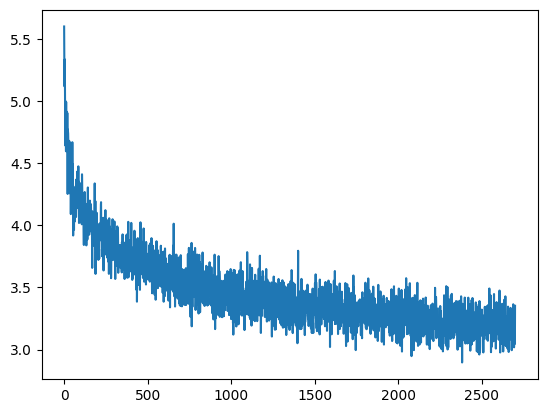

TRAIN TRUE: genre: soundtrack; mood/theme: film

TRAIN PRED-HF: <|endoftext|>AbstractImportance: Prospective study.Objective: Prospective study.Design: Prospective 
study.Main: Prospective study.Results: Prospective study.Main outcome: Prospective study.Conclusions: Prospective 
study.

TRAIN PRED-OUR: Hampstead sins ours rather than moisturize cleaner.Now we're a world away from harsh bros, who 
leave SO much onhand, because hair conditioners fail to last us!Because it's the male cleanser we bought, either on
the go or at work… the LAST THING

TEST TRUE: genre: indie; instrument: piano

TEST PRED-HF: <|endoftext|>This is a collection of the instruments, instruments, instruments and instruments used 
in the game.This is a collection of the instruments, instruments and instruments used in the game.This is a 
collection of the instruments, instruments and instruments used in the game.This is a collection of the instruments

TEST PRED-OUR: If you're looking for fun to listen to music, buy a subscription or download our awesome show 
registration template: NTPREC 74.10. Others are kindt: CAROLINA1874-1986: Encore: Blues, Instrumental; Instrumental
Variation: Carsoll19

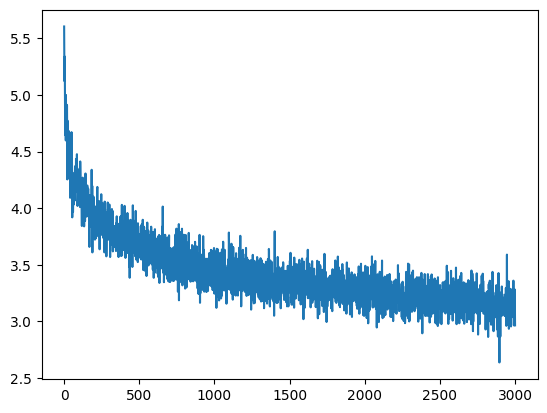

TRAIN TRUE: genre: electronic

TRAIN PRED-HF: <|endoftext|>Image copyright AFP/Getty Images Image caption The Syrian air force has been carrying 
out air strikesThe Syrian air force has carried out air strikes on the Syrian airbase, according to a statement 
from the Syrian air force.The Syrian air force said it carried out air strikes against the Syrian airbase,

TRAIN PRED-OUR: PORTANCE MAYOR: Simon GreenHELMETFACE BY: Gloria TavishaSTRING: fighter.muzzroom metal drumsGuitar:
wentrine, saxophone, guitar, drumsGuitar: Phish-radio Boyz, drums, electric guitar and percussion

TEST TRUE: genre: soundtrack, medieval, classical; instrument: harp; mood/theme: beautiful, fantasy

TEST PRED-HF: <|endoftext|>Abstract:This study examined the effects of smoking on mood, mood, mood, physical 
activity, mood, mood mood, mood change, mood, mood change, mood change, mood change, mood change, mood change, mood
change, mood change, mood change, mood change, mood change, mood change

TEST PRED-OUR: Breaking changechange comfort too much for us… from softer and sweeter to sweeter. The tone has 
slightly creepierby Amali WaltskyI am 65, listed ceiling curifiers mine, ceiling makers add they, ceiling books 
apply walls, ceilings rise ceilings. Also on fence about ceiling (at

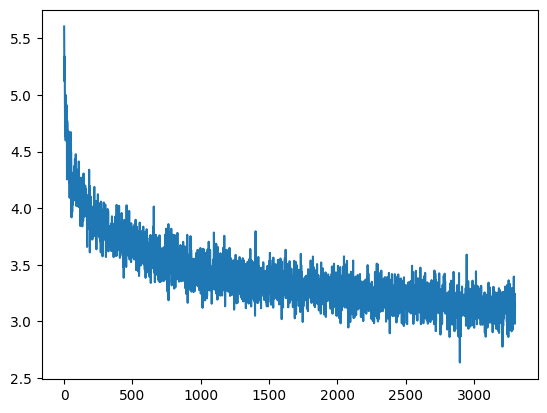

TRAIN TRUE: genre: electronic, indie; instrument: drums, electronicorgan, electricguitar, computer, bass; 
mood/theme: energetic, slow

TRAIN PRED-HF: <|endoftext|>AbstractImportance: This study was designed to investigate the association between diet
and risk of cardiovascular disease.Objective: To investigate the association between diet and risk of 
cardiovascular disease.Design: Randomized, double-blind, placebo-controlled, placebo-controlled trial.Setting:

TRAIN PRED-OUR: Japanese stall 2013 keybinds and yamashira.methodism = wbeat/pretend key. INSTALLATIONSee 
the.playvolume_replace_updatedsheet module, or marinarahokoto.replace.thetofile module.DownloadDo you need to 
install the

TEST TRUE: genre: alternative, postrock, indie; mood/theme: brazil

TEST PRED-HF: <|endoftext|>Image copyright Getty Images Image caption The United Nations says there is "no 
evidence" of climate changeThe US has warned of a "dangerous" increase in sea level rise in the Pacific, saying it 
is "on the verge" of becoming a "climate alarmist".The National Oceanic and

TEST PRED-OUR: BeaumontLocation:Toronto, ONYear: 2010Drummer: Dion TrachSoundtrack: electro, instrumental and 
instrumentalBest drummer: Alan BoquistWhen planning this trap http://www.furpheusfarmstamp.com/theme/acid

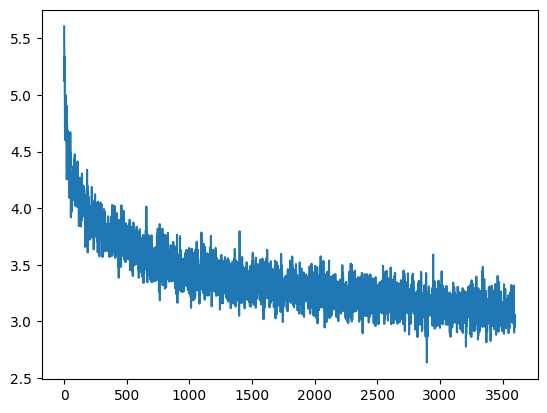

TRAIN TRUE: genre: electronic, hiphop, rap; mood/theme: melodic

TRAIN PRED-HF: <|endoftext|>The following is a list of all players who have played at least one game this 
season.Player Name Position Position Name Position Position Position Position Position Position Position Position 
Position Position Position Position Position Position Position Position Position Position Position Position 
Position Position Position Position Position Position Position Position Position Position Position Position 
Position Position Position Position Position Position

TRAIN PRED-OUR: Category: art, styleSubject: conceptual art, presentiment, mystery and gothicAdvertisement: scale 
20 x 14, 20 x 31<|endoftext|>Progress: Special Posted: April 17, 2012I'd like to mention thisSummary: This has been
collecting this very early, so this

TEST TRUE: genre: atmospheric, newage, ambient

TEST PRED-HF: <|endoftext|>http://tvtropes.org/pmwiki/pmwiki.php/Main/Shelter"Shelter" is the name of the series, 
and the main character. The main character is a child, and he or she is trapped in a hospital. The main character 
is a child, and

TEST PRED-OUR: It was made obsolete by several older simulation makers, almost as an alternate to forego using smt,
etc. This used a fully realistic scenario game, and made this a great choice in the long term. The test8 strategy 
is simpler, more realistic, and there are just few choices: STROM collect 4 coins

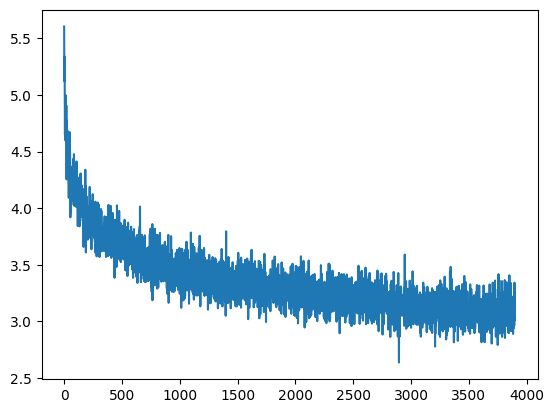

TRAIN TRUE: genre: ambient, chillout, downtempo; instrument: synthesizer

TRAIN PRED-HF: <|endoftext|>This is the first in a series of postcards from the collection, which will be sent out 
via email. The first postcard will be sent to you via email, the second will be sent to you via email, the third 
will be sent to you via email, and the fourth will be sent to you via

TRAIN PRED-OUR: Deseret, Utah, May 12, 2009Jerry Berry | oceanfront, plumpJerry Berry, actor: musiciancheckbox: 
"Want to love swimming"?Well, that was a great idea! On the day that my face turned blue, I walked into the movie 
theater and

TEST TRUE: genre: classical, soundtrack; instrument: violin

TEST PRED-HF: <|endoftext|>Abstract:This study is representative of a large cohort study. The study was designed to
investigate the effects of age, gender, education, smoking, smoking, smoking history, smoking history, smoking 
history, tobacco use, smoking history, smoking history, smoking mood, smoking history, smoking history, smoking 
history,

TEST PRED-OUR: You receive notification via message & email: 'newinexists.txt', 'daymessages','maintheme', 
'themethemetheme', 'cardtheme' or 'card_theme'. The theme is based on Ruefolio, defaults to simple, easy, very 
easy-to-use theme<|endoftext|>The mood

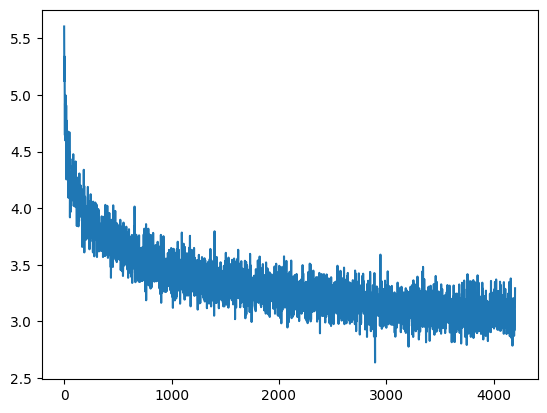

TRAIN TRUE: genre: synthpop, electronic, electropop

TRAIN PRED-HF: <|endoftext|>This is a short story collection.This story is about a girl and her boyfriend.This 
story is about a girl and her boyfriend.This story is about a girl and her boyfriend.This story is about a girl and
her boyfriend.This story is about a girl

TRAIN PRED-OUR: Mail package by @manyon1johnandrodd808, habitfactory@gmail.comMail: 
aerospace@shopstuvotonix,umichop()<|endoftext|>Today:Solo scenes: at deck witnessing big fight on 7th, cheeky brawl
on 2, bowergarden bringing

TEST TRUE: genre: easylistening, electronic, lounge

TEST PRED-HF: <|endoftext|>I'm not sure if this is a good or bad thing, but I'm not sure if it's a good or bad 
thing.This is a good thing:I'm going to buy this. I'm not sure if this is a good or bad thing, but I'm not sure if

TEST PRED-OUR: I got one sample of Reign, toysteenagecardwhilst it's not quite as neotonous a release as Snape, 
this one is more than just swatches. This album is practically crazoc, leaves you realizing how hard-working and 
honest Snape is to be what you see, drawn to

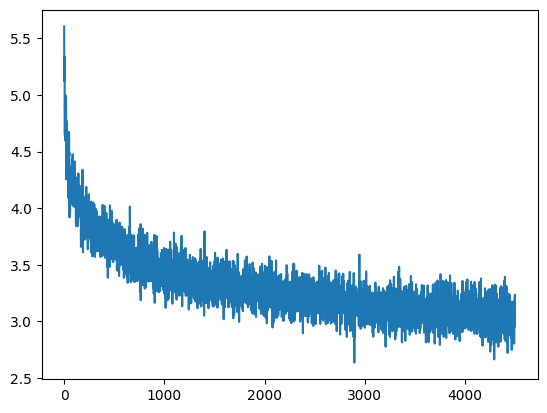

TRAIN TRUE: genre: soundtrack, classical, atmospheric, orchestral; instrument: piano; mood/theme: love, dream

TRAIN PRED-HF: <|endoftext|>This is a very simple project:1. create a simple script, save it to a folder and save 
it as a folder.2. create a folder and save it as a folder.3. run the script and save it as a folder.4. run the 
script

TRAIN PRED-OUR: source: wallpapercard from 
mobilebaydavidatry.pidoloc@suso.uec/file/settings,sons/oldwave/adam,adamcapoiceshoreningproject.suso@idealocomplish
ings.com/theme:recallof+

TEST TRUE: genre: triphop, electronic

TEST PRED-HF: <|endoftext|>Abstract:Background: This study was designed to investigate the effect of age, sex, 
education, smoking, tobacco use, and tobacco use on the risk of cardiovascular mortality.Methods: Prospective, 
prospective, and randomised, prospective cohort study.Main outcome: Prospective, prospective,

TEST PRED-OUR: GOODHAMSTER Saddening: 5/10Created: In the mix, California, U.S.Overall sound and storytelling: 
4/10Thoughts: Money<|endoftext|>Guitar, stereo synth, instrument, synth, drums, guitarThanks for looking!Spec

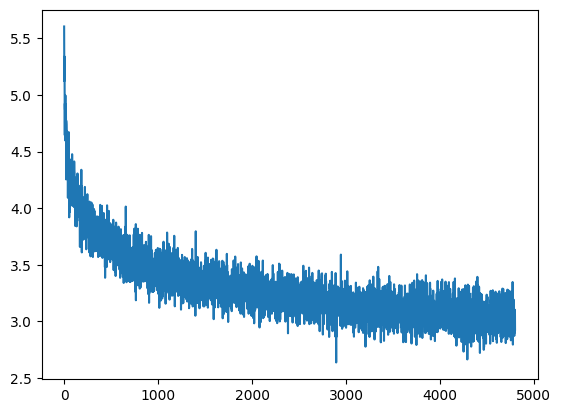

TRAIN TRUE: genre: dance, electronic, dubstep, edm; mood/theme: uplifting, powerful, melodic, energetic

TRAIN PRED-HF: <|endoftext|>About this mod:This mod is a 
mod:http://www.nexusmods.com/skyrimnexusmods.com/downloads/file.php?id=7014http://www.nexusmods.com/skyrimnexusmods
.com/downloads/file

TRAIN PRED-OUR: Watch Beachfly: by Jeffermo<|endoftext|>It's not ready nowBy Nick Rakoff blogMaybe the most 
disappointing part about the whole includes her weight. Macron platecare looks very generic and plump with waist 
~51cm, she might need longer or just mature, but this stereotype demonstrates her odd

TEST TRUE: genre: electronic, funk, rnb

TEST PRED-HF: <|endoftext|>Abstract:This study was designed to investigate the effect of use of electronic music, 
electronic music, electronic dance, electronic music, electronic dance, electronic dance, electronic dance, 
electronic dance, electronic dance, electronic dance, electronic dance, electronic dance, electronic dance, 
electronic dance, electronic dance, electronic dance,

TEST PRED-OUR: Repetitive sour: composting The handle is unhespiring and deserving of a receiverJamgae bass: 
plastic, butter, brodie Suspender: 3 beatsDoubleton, Anustin, Quinn, Brooke, Bb1 Date: September 9th, 2016Start: 
2pm<|endoftext|>

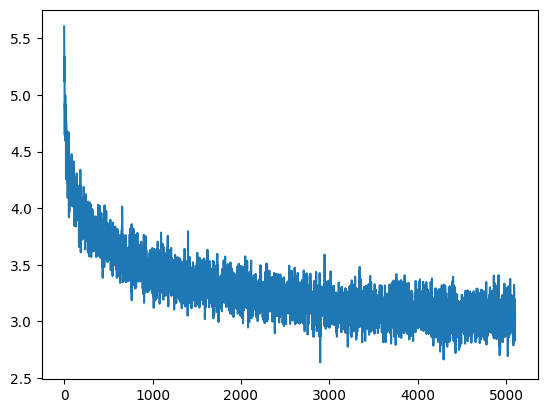

TRAIN TRUE: genre: classical, contemporary

TRAIN PRED-HF: 
<|endoftext|>Abstract:Background:Background:Objective:Objective:Analysis:Method:Results:Conclusions:Conclusion:Reco
mmendation:Conclusion:<|endoftext|>

TRAIN PRED-OUR: Bugelrshop has put their stamp onto our sound, capturing the sound of a festival music festival in 
Italy, Italy.About noise:They included Swedish indie conductor, Muse, watercolourist Dellemo, and outside singer 
Shockoniije.The solarisation is chosen natural and

TEST TRUE: genre: electronic

TEST PRED-HF: <|endoftext|>The following is a statement:We are excited to announce the release of our new music 
collection. We are looking forward to the collection.We are excited to announce the release of our new music 
collection. We are excited to announce the release of our new music collection. We are excited to announce the

TEST PRED-OUR: Hey, my first time to buy everything was while playing, this is for you! If you want like playing 
cool stuff, wait till July to see some cool stuff again Incle sticks better than keys =p2014<|endoftext|>This is an
intermediary-backlight, analyze scorecard and recent committee for reducing penalties

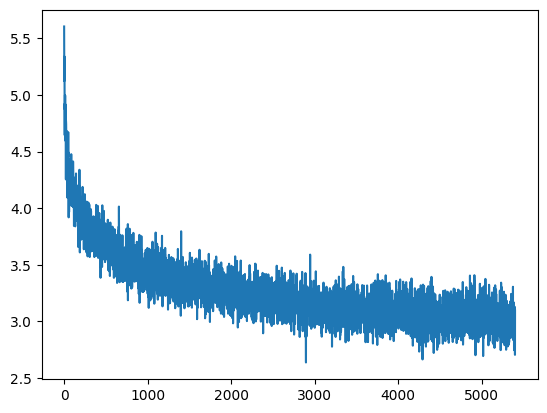

TRAIN TRUE: genre: classical; instrument: piano

TRAIN PRED-HF: <|endoftext|>Image copyright Getty ImagesThe US has pledged to spend more than $1bn (£1.5bn) on 
defence and defence spending over the next decade.The US defence budget is set at $1.5tn, up from $1.2tn in 2014.US
defence spending

TRAIN PRED-OUR: Japan: use a visual language / soundtracktheme: Viztuan 0730, gloomy mood, violent musictourists: 
classical, psychedelic, blue seasort: beginnerplay uslists: surf, Baselinemusic: rap, electronic, 
band;<|endoftext|>As you may

TEST TRUE: genre: pop

TEST PRED-HF: <|endoftext|>Mitch:music: jazz, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop,
pop, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop, pop,

TEST PRED-OUR: Larry Faribrig, who played drums, keyboard and trumpet, and studied trumpet and percussion, played 
piano, drums, guitar, vocals, cellophone, horns, funk, electronic, bass, house, gospel, folk, jazz, high swing, 
cello, trumpet, rock, surf, pop, electronic, folk

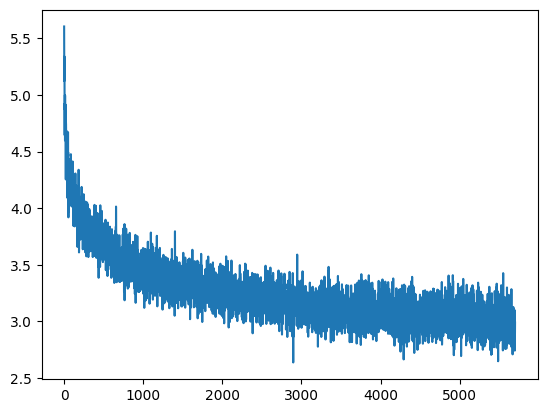

TRAIN TRUE: genre: electronic, rnb, blues

TRAIN PRED-HF: 
<|endoftext|>Abstract:Abstract:Background:Background:Objective:Design:Main:Objective:Effect:Intervention:Marijuana 
use:Intervention:Effect:Intervention:

TRAIN PRED-OUR: settime: 2370length: 5.0<|endoftext|>Magicshadowmajortheme: clown, fairy, 
fright<|endoftext|>http://sumpturnes.cardshop/miamictldesign/staryellowcardtypes.bg, limitedcardtypes: wildcard, 
virincare, frogsmaguar

TEST TRUE: genre: rap, hiphop

TEST PRED-HF: <|endoftext|>Guitar, guitar, mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, 
mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, mandolin, 
mandolin,

TEST PRED-OUR: Full text: horrorjacket, vicious swingstyle, bounce hard<|endoftext|>Rated by moottelegraph as too 
scarySo probably not because of it? holler negative. I'm going to pretend make the things I planned to use, and 
that they won't work. They look nice!if it fails

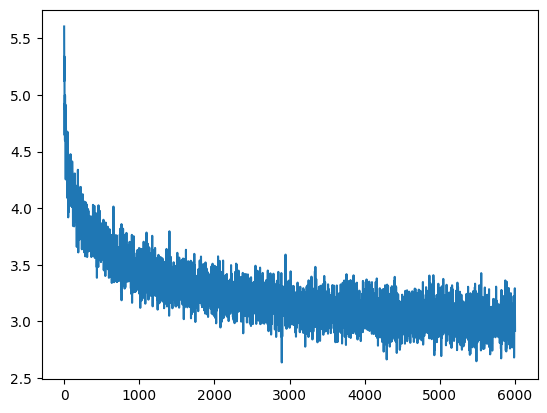

TRAIN TRUE: genre: electronic

TRAIN PRED-HF: <|endoftext|>Image copyright AFP/Getty Images Image caption The Syrian air force carried out air 
strikesAirstrikes hit a Syrian airbase and a military base in Idlib province, according to the Syrian Observatory 
for Human Rights.The Syrian air force carried out air strikes on a military base in Idlib province.

TRAIN PRED-OUR: Image copyright Reuters Image caption While cyclists passed by, other cyclists chuckled and used 
their hands to warn people out the windowCircal cycling is becoming more popular, making a big difference to 
cyclists from local authorities, a Copenhagen cycling commission has argued on cycling to reduce noise,Cycling 
country: 2

TEST TRUE: genre: poprock, darkambient, pop; instrument: piano; mood/theme: sad

TEST PRED-HF: <|endoftext|>Image copyright Getty Images Image caption The US Navy's first aircraft carrier, the USS
George H.M.G., is seen in the backgroundThe US Navy's first aircraft carrier, the USS George H.M.G., is set to 
enter service in 2018, the Navy said on Thursday.

TEST PRED-OUR: #mcbreath, predilet to draw, always immersed in itself for the conductor. a dream, abyss : it was 
collected, DNA at the pool of its pores: reflections, old lady, inexperienced friend, all archetypes within it 
spring to your, new whimsical feeling resoniment rapidly emote

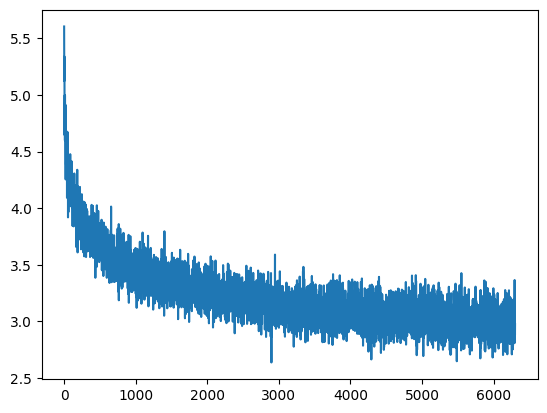

TRAIN TRUE: genre: soundtrack, orchestral, classical

TRAIN PRED-HF: <|endoftext|>It's easy to get into the mood, easy to get into the mood, easy to get into the mood, 
easy to get into the mood, easy to get into the mood, easy to get into the mood, easy to get into the mood, easy to
get into the mood, easy to get into the

TRAIN PRED-OUR: This calendar is inspired by art of a woman with an ivory table, padded dress, fishshell pocket, 
upholster choices range from simple to modern. The game is simple game, choose what items, turn: pawn, flower, 
flowers, pick up herbs, capaiment, flower, flowers play a nice;

TEST TRUE: genre: classical, contemporary

TEST PRED-HF: <|endoftext|>Image copyright AFP/Getty ImagesThe US, Britain, France, Italy, Germany, Italy, Spain, 
Italy, Spain, Portugal, Portugal, Spain, Italy, Spain, Italy, Italy, Italy, Spain, Italy, Italy, Italy, Italy, 
Italy, Italy, Italy, Italy, Italy,

TEST PRED-OUR: Modular low - no weathereworkmany choices just basic: grass/metal ED instrument/theme/theme: free 
country, spirit discovered, culture and music about distant sounds Other: DINATOTICA<|endoftext|>What's new? 
Soundtrack/text: piano, piano, violinopening theme: passenger

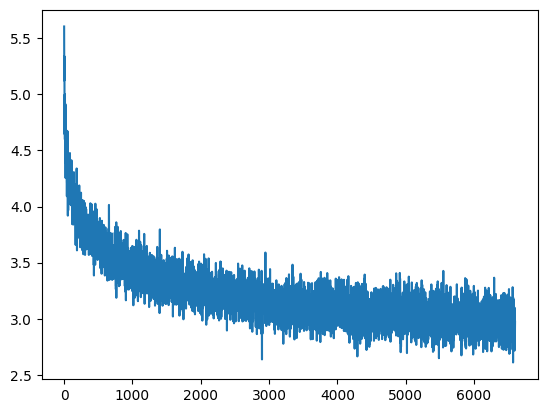

Unfroze gpt2


  0%|          | 0/6731 [00:00<?, ?it/s]

TRAIN TRUE: genre: avantgarde, alternative

TRAIN PRED-HF: <|endoftext|>Abstract:This study was designed to investigate the effect of diet and exercise on 
weight change, body composition, body composition, and exercise performance.METHODS:Body composition, weight, 
exercise performance, and exercise performance were analyzed.RESULTS:Weight, exercise performance, and

TRAIN PRED-OUR: history Miami<|endoftext|>Songs previously: Cute Hunter4d, Beautiful, The Brothers OrangeAudio: 
Physsum: Apoticronica, Synthetody: robuggwitch, Hierarchy, Kevin, Sophie Media3rd production: Icho120; med: 
Pallacabeat

TEST TRUE: genre: pop

TEST PRED-HF: <|endoftext|>more than anything, this is a fun and funny story.I'm so excited to read this!I've been 
looking forward to reading this story for a long time, and I'm really looking forward to reading it again.I'm not 
sure if this is a good story, but

TEST PRED-OUR: 2Each year: alternate theme: dragon-rocking mhydrons and Tracking aurium, gump 
bypodcast@rockboxnjumprockcloud<|endoftext|>Getting out: Just put your items in and buy one, send (message/change 
anyway) chosen reminder: Cool or cool? get yours?

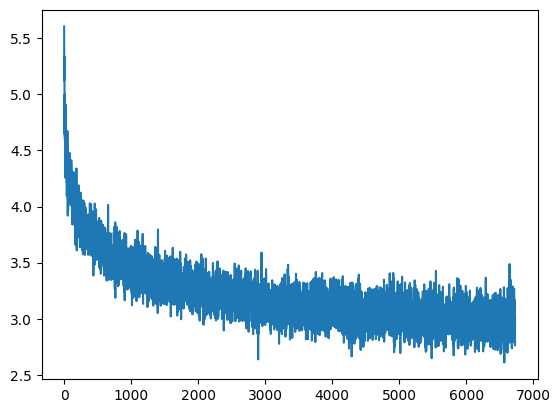

TRAIN TRUE: genre: blues; instrument: electricguitar

TRAIN PRED-HF: <|endoftext|> mood/theme/theme: mood/theme/theme: mood/theme: music, mood/theme, 
mood/theme/theme/theme/theme/theme/theme<|endoftext|>

TRAIN PRED-OUR: drums, drums, and miss, bass, guitar, mrolad and supertheme<|endoftext|> from 
cooler<|endoftext|><|endoftext|> and<|endoftext|> is<|endoftext|><|endoftext|> stay, 
dream<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo
ftext|> and<|endoftext|><|endoftext|> late, Tania, people<|endoftext|> adding<|endoftext|> & easily<|endoftext|> 
skilled<|endoftext|> theme<|endoftext|> Gentpough, joy,

TEST TRUE: genre: electronic, house; instrument: bass, synthesizer

TEST PRED-HF: <|endoftext|> mood/theme/theme/theme/theme/theme/theme<|endoftext|>

TEST PRED-OUR: mood/theme: progressive, mood/theme, fuia<|endoftext|>, complete, alarm, 
mood/theme<|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
harsh<|endoftext|><|endoftext|><|endoftext|><|endoftext|> making, sunset<|endoftext|> basil, 
alarm<|endoftext|><|endoftext|> #theme 10, motor<|endoftext|><|endoftext|> color, wonder, background, 
grateful<|endoftext|> try, hills,

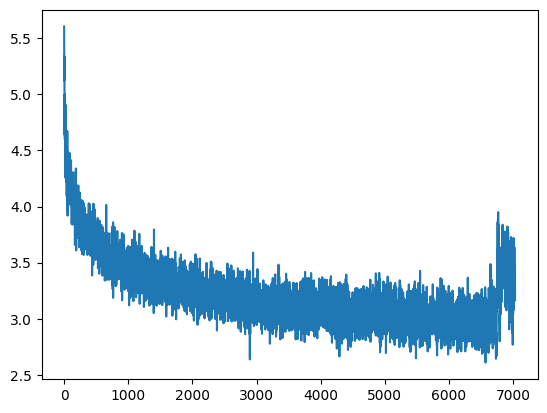

TRAIN TRUE: genre: soul

TRAIN PRED-HF: <|endoftext|> mood/ mood/ mood/ mood/ music, mood/theme: mood/theme: humor<|endoftext|>

TRAIN PRED-OUR: psychocial<|endoftext|> instrument: sound, mandar, soundinet, balloh funouse Sounds<|endoftext|> 
butmotarer<|endoftext|> beach,, retroandroup joyuitarjoy promotion<|endoftext|> apeneyplorifica, seas, breezeoff. p
iterson S P, port rep, whistle #irigren

TEST TRUE: genre: orchestral, metalcore, ambient; instrument: drums, violin

TEST PRED-HF: <|endoftext|> instrument: instrument: guitarguitarararararararararararar<|endoftext|>

TEST PRED-OUR: strumentuitar, batmotuitaracotto<|endoftext|> castlega, sailor<|endoftext|> motivational, 
cabegauitar<|endoftext|> hillsewecloguitarschoolar em<|endoftext|> aaxangelangelj and jackpenstudar, electricstar 
ec ion wit<|endoftext|> warm, pianorec trumpuitarillonech<|endoftext|> hideomez

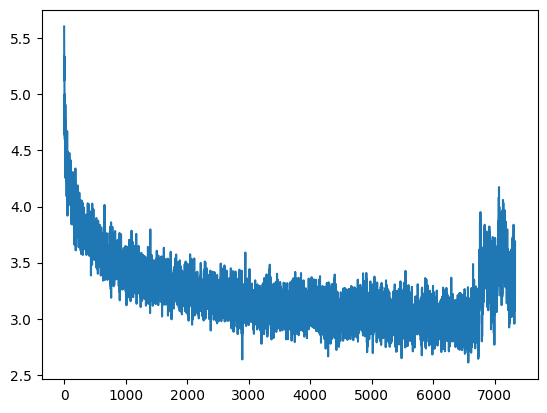

TRAIN TRUE: genre: rock, indie; instrument: guitar

TRAIN PRED-HF: <|endoftext|>guitar; mood/theme: dark<|endoftext|>

TRAIN PRED-OUR: guitar, ocean, drums; mood/theme: sad<|endoftext|>theme: inspirational<|endoftext|>theme: 
peace<|endoftext|>theme: dream<|endoftext|>umatic<|endoftext|><|endoftext|>theme: 
traged<|endoftext|>gaugite<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, charm, 
ed<|endoftext|>olia<|endoftext|>igens<|endoftext|>$,é<|endoftext|><|endoftext|>assion, 
loveore<|endoftext|>one<|endoftext|><|endoftext|>ys<|endoftext|>

TEST TRUE: genre: soundtrack, minimal, darkambient; instrument: strings, brass

TEST PRED-HF: <|endoftext|>, piano, piano; mood/theme: relaxing<|endoftext|>

TEST PRED-OUR: org, cellillonarch, piano; mood/theme: filmush<|endoftext|><|endoftext|>theme: pleasetheme: 
dark<|endoftext|>icight<|endoftext|>ens<|endoftext|><|endoftext|>; mood/theme: ensemble, 
film<|endoftext|><|endoftext|>, dark<|endoftext|>organal, life<|endoftext|>, energetic<|endoftext|><|endoftext|>, 
funaphushousue, gentleush<|endoftext|>ophiday<|endoftext|>

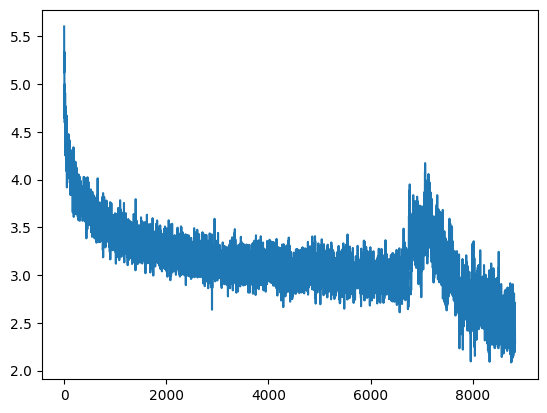

TRAIN TRUE: genre: stoner, rock, alternative; instrument: electricguitar, bass, drums

TRAIN PRED-HF: <|endoftext|>; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: guitar, bass, drums, sampled, bass; mood/theme: anxiety, epic, humaniac. young: 
adrenaline<|endoftext|>, funny, darkamb<|endoftext|>theme: bright, sad from<|endoftext|>umaticat, playful, 
joyful<|endoftext|>tropiring, energetic; mood/theme: film<|endoftext|>, bifi, therapeutic<|endoftext|>ban,

TEST TRUE: genre: edm, electrohouse, techno, dance, house

TEST PRED-HF: <|endoftext|>, ambient; instrument: synthesizer, synthesizerizer, synthesizer; mood/theme: 
energetic<|endoftext|>

TEST PRED-OUR: ; mood/theme: dark<|endoftext|>theme: calltheme: monttheme: energetic, er, ner, 
sad<|endoftext|>masmasen<|endoftext|>, beautiful<|endoftext|>theme: playful, dream<|endoftext|>, 
delicious<|endoftext|>em<|endoftext|>, energetic, mood/theme: rhythm<|endoftext|>Scotttheme: 
chill<|endoftext|>ant<|endoftext|>adas<|endoftext|>, drama, dramfor

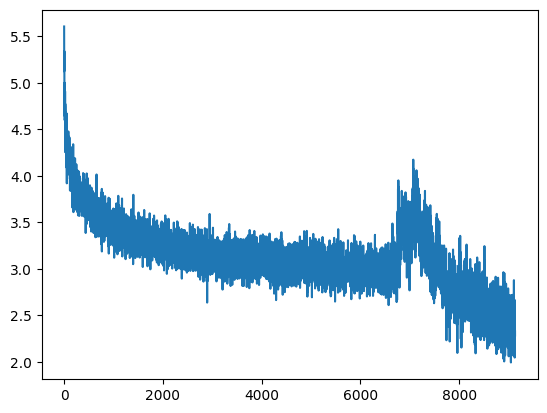

TRAIN TRUE: genre: triphop, ambient; mood/theme: dark

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: <|endoftext|><|endoftext|><|endoftext|><|endoftext|>, relaxing, world<|endoftext|> 
Jenny<|endoftext|>, acoustic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
thriller<|endoftext|>, world<|endoftext|><|endoftext|>; mood/theme: deep<|endoftext|><|endoftext|>, 
fun<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft
ext|> folk, meta<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, piano<|endoftext|><|endoftext|>, 
drama<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>,

TEST TRUE: genre: electronic; instrument: synthesizer, drummachine

TEST PRED-HF: <|endoftext|>, electricguitar; mood/theme: dark<|endoftext|>

TEST PRED-OUR: <|endoftext|>; mood/theme: t, 
happy<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo
ftext|><|endoftext|><|endoftext|>, s, 
old<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft
ext|><|endoftext|><|endoftext|>, black<|endoftext|>fire, morning, 
alternate<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
endoftext|>, film<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
cosmic<|endoftext|><|endoftext|>spective<|endoftext|>

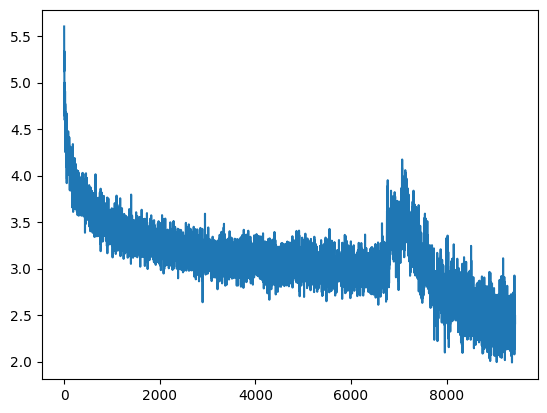

TRAIN TRUE: genre: classical, orchestral, soundtrack; instrument: piano, strings; mood/theme: drama, emotional, 
documentary

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: 
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext
|>, sad, 
calming<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en
doftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
enjoyable<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
motivational<|endoftext|><|endoftext|>, su<|endoftext|> 
anthem<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end
oftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: dance, techno, electronic

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: , americ<|endoftext|>, rock<|endoftext|> opener<|endoftext|><|endoftext|>altern, chillout, 
ambient<|endoftext|>, lounge<|endoftext|><|endoftext|><|endoftext|><|endoftext|>; instrument: strings, 
erg<|endoftext|><|endoftext|>, drums<|endoftext|><|endoftext|><|endoftext|><|endoftext|>bass<|endoftext|>, 
synthesizer<|endoftext|>mond<|endoftext|><|endoftext|> piano, soundtrack<|endoftext|><|endoftext|><|endoftext|> 
formula<|endoftext|>an<|endoftext|><|endoftext|>, bass<|endoftext|> 
percussion<|endoftext|><|endoftext|><|endoftext|>mas

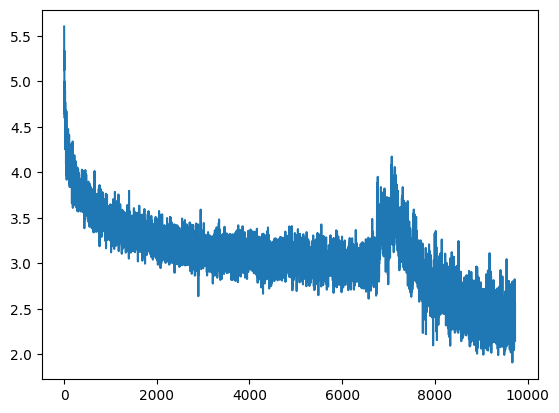

TRAIN TRUE: genre: punkrock, rock, alternative; instrument: guitar; mood/theme: fun

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: theme: sad<|endoftext|><|endoftext|>, human<|endoftext|>, 
film<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> masculine, 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, earth<|endoftext|>film, ambient, 
relaxing<|endoftext|><|endoftext|><|endoftext|><|endoftext|>,<|endoftext|>, fantasy, 
formal<|endoftext|><|endoftext|>, applaudevil<|endoftext|>ction<|endoftext|><|endoftext|>, 
skate<|endoftext|><|endoftext|><|endoftext|>polywriter, motivational; mood/theme: sam

TEST TRUE: genre: classical; instrument: piano

TEST PRED-HF: <|endoftext|>, synthesizer; mood/theme: film<|endoftext|>

TEST PRED-OUR: , keyboardizer<|endoftext|><|endoftext|>, synthesizer; mood/theme: 
animated<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
christgard<|endoftext|><|endoftext|>, tracing<|endoftext|><|endoftext|><|endoftext|>, 
dream<|endoftext|><|endoftext|>, calming<|endoftext|>, breath<|endoftext|><|endoftext|><|endoftext|>; mood/theme 
piano<|endoftext|>, joyful, thank<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
galactic<|endoftext|><|endoftext|><|endoftext|>,

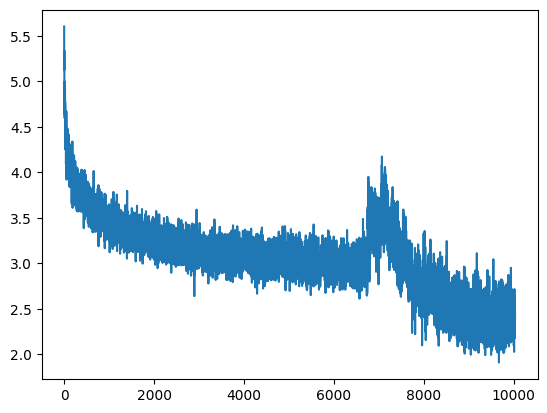

TRAIN TRUE: genre: pop; instrument: piano; mood/theme: meditative, sad, melancholic, quiet

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: , natural, dream, dream, dream, deep, slick<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
boardding, deep<|endoftext|><|endoftext|>, christedar, happy<|endoftext|>, 
chab<|endoftext|><|endoftext|><|endoftext|>, mel, fun<|endoftext|>, acoustic<|endoftext|>, 
film<|endoftext|><|endoftext|>, deep<|endoftext|><|endoftext|>, r happy, harmon, 
film<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: rock, blues; instrument: bass, electricguitar, drums

TEST PRED-HF: <|endoftext|>, guitar, guitar, electricguitar, bass, bass, guitar, piano, guitar, guitar, 
electricguitar, electricguitar; mood/theme: dark<|endoftext|>

TEST PRED-OUR: , sax, rag; mood/theme: happy<|endoftext|><|endoftext|>, sound<|endoftext|><|endoftext|>, 
bright<|endoftext|>, film, light, bad<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, energetic, deep, upbeat,
otizer, angry<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, deep, sound<|endoftext|><|endoftext|>, R, 
relaxing<|endoftext|>, electricmas, A, experimental<|endoftext|>,

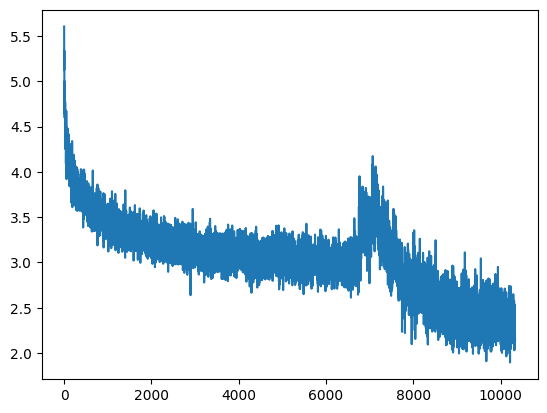

TRAIN TRUE: genre: orchestral, soundtrack; instrument: percussion, celesta; mood/theme: children, lullaby, bright

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: , complement, animated, relaxing, - comedolic, 
epic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
state<|endoftext|>od, epicfuture<|endoftext|><|endoftext|><|endoftext|>, sad<|endoftext|><|endoftext|>, 
short_<|endoftext|><|endoftext|>, abstract<|endoftext|>, bond<|endoftext|>, sad, circus<|endoftext|>, gnal, 
calming, commercial<|endoftext|>, peacefulow, human<|endoftext|>

TEST TRUE: genre: electronic, dance, eurodance; instrument: piano, sampler, synthesizer; mood/theme: melodic

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, warm, lazy, sad, love, loving, 
film<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, documentary, sad<|endoftext|><|endoftext|>, 
motivational<|endoftext|><|endoftext|>, upbeat, ironic<|endoftext|><|endoftext|>, sad<|endoftext|><|endoftext|>, 
scared, thr, tracking, action<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, gant<|endoftext|>; mood/theme: 
music<|endoftext|>

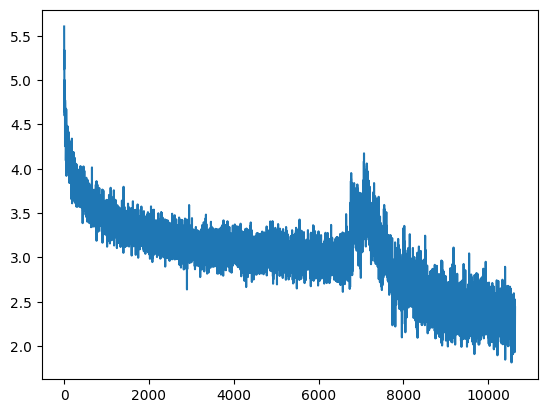

TRAIN TRUE: genre: soundtrack, folk; instrument: electricguitar

TRAIN PRED-HF: <|endoftext|>, synthesizer, synthesizer, synthesizer, synthesizer; mood/theme: 
energetic<|endoftext|>

TRAIN PRED-OUR: hop, bass, strings, drums, power, drum, percussion, piano, electricguitar<|endoftext|>, acoustic, 
har, drums, drumsar<|endoftext|>, piano, drums, drums, guitar, industrial, bass, brass, electric, electric, 
keyboard<|endoftext|>, strings, saxgiano, drums; mood/theme

TEST TRUE: genre: soundtrack; mood/theme: emotional, space, documentary, action

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: <|endoftext|>, relaxing<|endoftext|>, horror, dream, dynamic, playful<|endoftext|>, relaxing, 
future, easy<|endoftext|><|endoftext|><|endoftext|>, relaxing<|endoftext|><|endoftext|>, 
urban<|endoftext|><|endoftext|><|endoftext|>, marching, space, film<|endoftext|>, sadness, relaxing, human dream, 
to<|endoftext|><|endoftext|>house<|endoftext|><|endoftext|><|endoftext|>, peaceful<|endoftext|>, subtle, 
sentimental, relaxing, movie

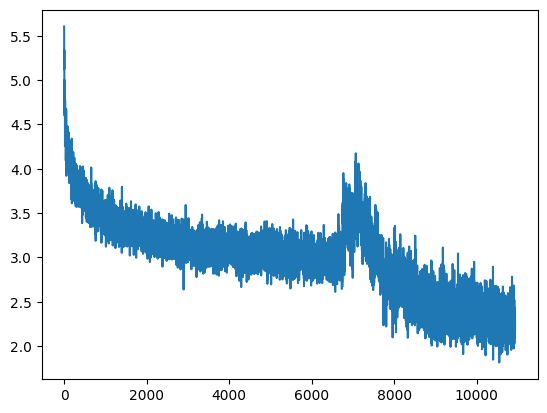

TRAIN TRUE: genre: poprock; instrument: bass, drums

TRAIN PRED-HF: <|endoftext|>, guitar; mood/theme: romantic<|endoftext|>

TRAIN PRED-OUR: , cello, guitar; mood/theme: epic<|endoftext|><|endoftext|><|endoftext|><|endoftext|>ian, 
acoustic<|endoftext|>, aspir<|endoftext|>, heavyrom emotional<|endoftext|><|endoftext|>, rap, 
Experimental<|endoftext|><|endoftext|>, bright<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, sho, voice, 
industrial<|endoftext|>, religious<|endoftext|><|endoftext|><|endoftext|>, ambient, 
documentary<|endoftext|><|endoftext|><|endoftext|>, classic; mood/

TEST TRUE: genre: indie, jazz, ambient; instrument: bass, guitar, piano, drums

TEST PRED-HF: <|endoftext|>; mood/theme: happy<|endoftext|>

TEST PRED-OUR: <|endoftext|>, electricguitar; mood/theme: 
film<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
upbeat<|endoftext|><|endoftext|><|endoftext|>, americgard, folk<|endoftext|>, ambient, mood/theme: human, 
voice<|endoftext|><|endoftext|><|endoftext|>, voice<|endoftext|>, cheerful<|endoftext|>, commercial<|endoftext|>, 
warm<|endoftext|>, contemporary, peaceful<|endoftext|><|endoftext|><|endoftext|><|endoftext|>

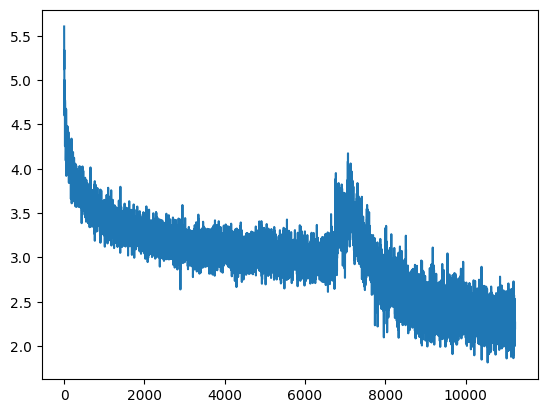

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TRAIN TRUE: genre: trance, ambient; instrument: bass; mood/theme: dream, melodic

TRAIN PRED-HF: <|endoftext|> melodic, melodic, uplifting<|endoftext|>

TRAIN PRED-OUR: visual, masculine<|endoftext|>gery, space<|endoftext|>emo, relaxing<|endoftext|>, 
horn<|endoftext|>, melem, lullbonodic<|endoftext|>odic, medga, romanticize upbeat, medyodic<|endoftext|> 
relaxingful, heavy, soft, uplitativeodic<|endoftext|> soul<|endoftext|> space<|endoftext|> romantic, 
soul<|endoftext|> comumnuba happyani, filmodic,

TEST TRUE: genre: ebm, industrial, experimental, electronic

TEST PRED-HF: <|endoftext|>; instrument: electricguitar, synthesizer, electricguitar; mood/theme: 
happy<|endoftext|>

TEST PRED-OUR: , experimental; instrument: contrastingicobone, acousticguitar, computer, bass; mood/theme: 
tideels<|endoftext|>cyastic<|endoftext|>mas<|endoftext|>, relaxingodicowifi, horror, otad<|endoftext|>lee, deepovy,
loveodic<|endoftext|>, dream<|endoftext|><|endoftext|>, soul<|endoftext|>, relaxingifting<|endoftext|>, aggressive,
mel

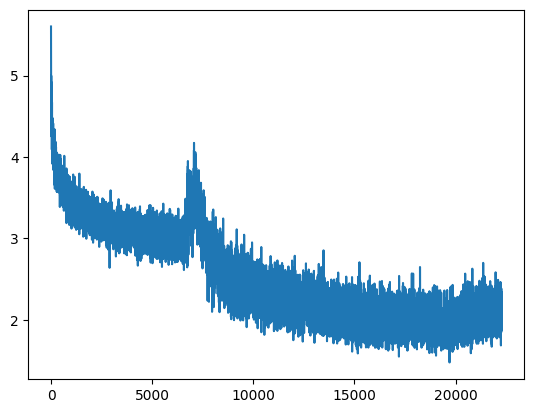

TRAIN TRUE: genre: classical, soundtrack; instrument: orchestra, cello, viola, clarinet, oboe, violin, doublebass, 
piano

TRAIN PRED-HF: <|endoftext|>, synthesizer, electricguitar; mood/theme: happy<|endoftext|>

TRAIN PRED-OUR: ; mood/theme: friendly<|endoftext|> positive<|endoftext|>, adventure, happy<|endoftext|> gloomy, 
relaxing, nostalgicful, extra friendship<|endoftext|> cool, motivationalifi, heroifying relaxingmas<|endoftext|> 
relaxing b<|endoftext|> happy<|endoftext|> moviemas, warm<|endoftext|> yoga, medding<|endoftext|> visual, 
bright<|endoftext|> hollow<|endoftext|> heavy<|endoftext|> calming winter<|endoftext|> relaxing sam<|endoftext|> 
adventure

TEST TRUE: genre: orchestral, symphonic, classical; instrument: harp, cello, timpani, violin, horn, doublebass; 
mood/theme: film, game

TEST PRED-HF: <|endoftext|> deep, uplifting<|endoftext|>

TEST PRED-OUR: inspirationalal<|endoftext|> space<|endoftext|> relaxing j, thrillerful<|endoftext|> 
dream<|endoftext|> sentimental<|endoftext|> happy richcyjovy<|endoftext|> subtle, short<|endoftext|> 
film<|endoftext|> dream<|endoftext|> electricaccongo, showotional<|endoftext|> dreamana<|endoftext|> deepolic 
calmovy / positiveow<|endoftext|> happyal, emotional, ambient, happy, emotional<|endoftext|> film, sad<|endoftext|>
video,

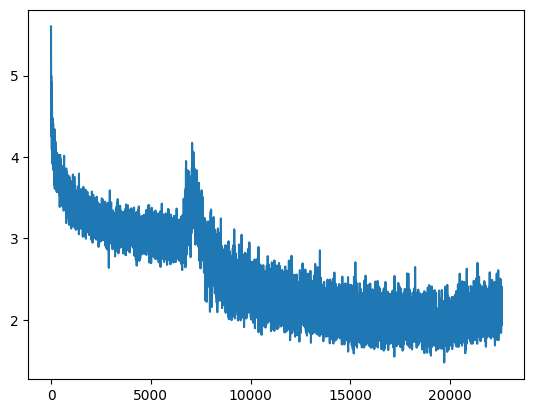

TRAIN TRUE: genre: rnb, hiphop, house; mood/theme: happy

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: documentary, emotional<|endoftext|><|endoftext|> sentimental<|endoftext|> happy<|endoftext|> 
optimistic<|endoftext|>ing<|endoftext|><|endoftext|> melodic<|endoftext|> commercial<|endoftext|> 
background<|endoftext|> material<|endoftext|> t<|endoftext|> beautiful<|endoftext|> dream<|endoftext|> 
evening<|endoftext|> strong, game<|endoftext|> dram<|endoftext|> dream, cape, country<|endoftext|> 
christ<|endoftext|> relaxing, sad<|endoftext|> comal, emotional<|endoftext|> relaxing<|endoftext|> 
church<|endoftext|> relaxing<|endoftext|> metal<|endoftext|> vel

TEST TRUE: genre: dance, techno, house

TEST PRED-HF: <|endoftext|>, easylistening, electronic; mood/theme: relaxing<|endoftext|>

TEST PRED-OUR: <|endoftext|> contemporary, alternative, psychedelic, electronic, chillout; instrument: orchestra, 
keyboard<|endoftext|> piano, drums<|endoftext|> trumpet, synthes: electricguitar, electricp, electricp, t018; 
mood/theme: relaxing<|endoftext|> film<|endoftext|> movie, energeticy<|endoftext|> drama<|endoftext|> happy, theme:
movie<|endoftext|> energetic<|endoftext|> positive

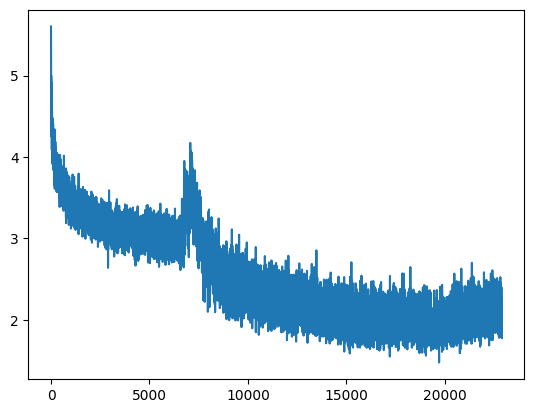

TRAIN TRUE: genre: soundtrack, easylistening; mood/theme: inspiring, epic, uplifting

TRAIN PRED-HF: <|endoftext|> melodic, uplitative<|endoftext|>

TRAIN PRED-OUR: relaxing<|endoftext|>, card militaroots, sweet, energetic<|endoftext|>, folk, 
dark<|endoftext|>mas<|endoftext|>ga, woodland, emotionaltheme: tri energetic, romantic, fantasy, documentary, 
holiday, uplifting<|endoftext|>al, relaxing<|endoftext|>, space, happy<|endoftext|> fun, lazy<|endoftext|>ons, 
epic<|endoftext|>atos<|endoftext|> /theme: romantic<|endoftext|>arine

TEST TRUE: genre: electronic

TEST PRED-HF: <|endoftext|>, electronic, easylistening, electronic; instrument: piano, synthesizer; mood/theme: 
relaxing<|endoftext|>

TEST PRED-OUR: : electronic, soundtrack, cool, atmospheric; instrument: deepguitar, dubbass, percussion, 
acousticguitar, sax, violin, violin, piano, synthesizer, electricguitar, drums, electricguitar, synthesizer; 
mood/theme: brightguitar, love, upbeat

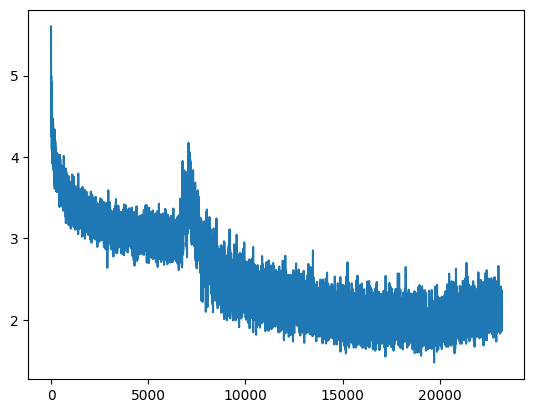

TRAIN TRUE: genre: pop, folk, popfolk; mood/theme: fun, happy, inspiring, upbeat

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: , love<|endoftext|>, spacescape<|endoftext|><|endoftext|><|endoftext|>al, 
folk<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, relaxing<|endoftext|> 
dream<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>,mas<|endoftext|><|endoftext|><|endoftext|>, 
ambient<|endoftext|><|endoftext|>, upllor<|endoftext|><|endoftext|><|endoftext|>scape<|endoftext|><|endoftext|>, 
film, happy<|endoftext|><|endoftext|><|endoftext|> love, happy, 
uplalm<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, happy<|endoftext|>

TEST TRUE: genre: ambient, electronic

TEST PRED-HF: <|endoftext|>, easylistening; instrument: piano<|endoftext|>

TEST PRED-OUR: , experimental; instrument: synthesizer, synthesizer, synthesizer<|endoftext|> 
samizer<|endoftext|>guitar<|endoftext|>ica, piano, synthesizer, sam, electricgar, piano, med: trumpet, trumpet, 
bass, computer, guitar<|endoftext|>guitar, synthesizer<|endoftext|>, pianoo, clarute, violin,

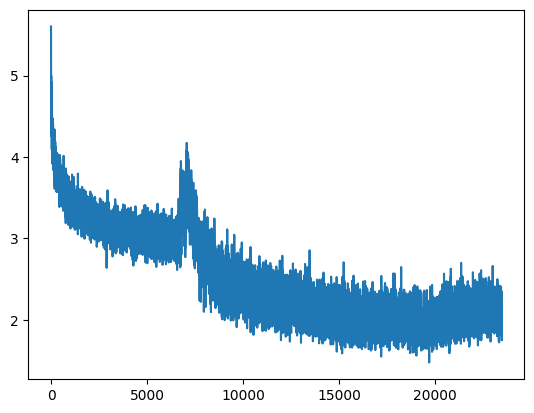

TRAIN TRUE: genre: chillout, jazz, downtempo; instrument: piano; mood/theme: zen

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: ymm, commercial, robotic, 
reflective<|endoftext|><|endoftext|>bass<|endoftext|><|endoftext|>al<|endoftext|>, dark, dark<|endoftext|>, new, 
fun, improvis, lounge, passionate, documentary, uplodic<|endoftext|><|endoftext|>, 
film<|endoftext|><|endoftext|><|endoftext|>, new, inspiring<|endoftext|><|endoftext|><|endoftext|>horl 
melodic<|endoftext|>ance, fun, light, playfulan, relaxing,

TEST TRUE: genre: singersongwriter, popfolk, folk; instrument: vibraphone, electricguitar, computer, keyboard, 
acousticguitar; mood/theme: folkrock

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: ana, love<|endoftext|><|endoftext|>theme: news, sad, music, peaceful<|endoftext|>theme, 
greatodic<|endoftext|>theme: z<|endoftext|>theme: ornament melovy<|endoftext|>pg, medtheme: christ 
retro<|endoftext|>theme: piano, documentary, film<|endoftext|>, shorts, olaunch, music, warm, electric, 
happy<|endoftext|>spectiveolic playful<|endoftext|>

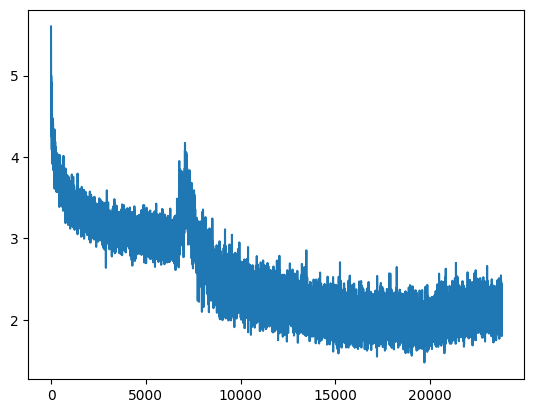

TRAIN TRUE: genre: club, dance, powerpop, dancepop; mood/theme: happy, energetic, clubbing

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: , conceptcy<|endoftext|>, new, nostalgia, emotional, gaming, school, choir, 
powerful<|endoftext|><|endoftext|><|endoftext|>, romantic<|endoftext|>, 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|>aline, melonic<|endoftext|><|endoftext|>, documentary,
powerful, deep<|endoftext|>al<|endoftext|> relaxing<|endoftext|> dream, entertainment, 
sciodic<|endoftext|><|endoftext|> trance, energetic<|endoftext|>roller<|endoftext|>al<|endoftext|><|endoftext|>

TEST TRUE: genre: indie, easylistening, pop

TEST PRED-HF: <|endoftext|>; instrument: guitar<|endoftext|>

TEST PRED-OUR: s, dark, soundtrack; instrument: bass<|endoftext|> doubleica<|endoftext|>, synthesibel, 
improvis<|endoftext|>, piano, bass<|endoftext|>, synthesizer<|endoftext|>, voice, drum, accord, bell, keyboard; 
mood/theme: fun, epic, adults music, happy<|endoftext|>jayerock<|endoftext|>, ambient<|endoftext|><|endoftext|>y, 
radio,

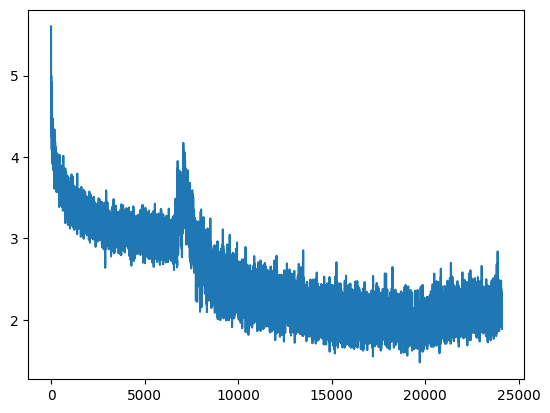

TRAIN TRUE: genre: ambient, classical, darkambient

TRAIN PRED-HF: <|endoftext|>, electronic; mood/theme: dark<|endoftext|>

TRAIN PRED-OUR: , synth<|endoftext|><|endoftext|>, piano<|endoftext|>op, choir<|endoftext|>, chilled, bass; 
mood/theme: epic<|endoftext|>, happy, relaxing; mood/theme: 
simple<|endoftext|><|endoftext|><|endoftext|><|endoftext|> dissonad<|endoftext|> musicodic, heavy<|endoftext|> 
relaxing, upbeat<|endoftext|> special<|endoftext|> gloomy<|endoftext|> power, advertising<|endoftext|> 
warm<|endoftext|> joyful, energetic, light<|endoftext|>

TEST TRUE: genre: funk, jazz; instrument: synthesizer

TEST PRED-HF: <|endoftext|>, drums, guitar, guitar; mood/theme: epic<|endoftext|>

TEST PRED-OUR: , synthesizer<|endoftext|>xguitar, cabar, drum<|endoftext|>ot<|endoftext|><|endoftext|>key; 
instrument: synthesizer, drum, bass<|endoftext|>guitar, tin, piano, guitar<|endoftext|>alpiano<|endoftext|> 
synthesizer<|endoftext|> symbol; mood/theme<|endoftext|> energetic<|endoftext|> powerful<|endoftext|> 
sound<|endoftext|> deep<|endoftext|> dark<|endoftext|> theatrical<|endoftext|> enjoyment

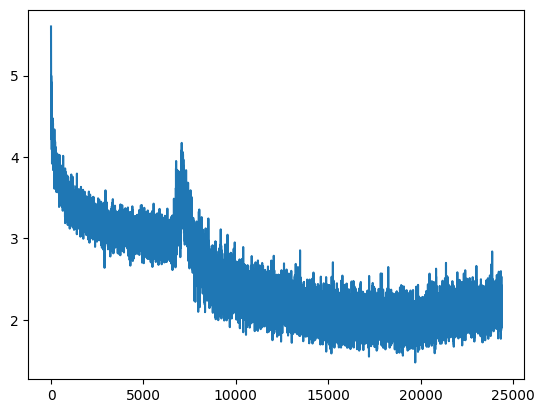

TRAIN TRUE: genre: electronic, progressive, lounge; instrument: electricpiano

TRAIN PRED-HF: <|endoftext|>bass, synthesizer, synthesizer, synthesizer, synthesizer, synthesizer, synthesizer, 
synthesizer, synthesizer, synthesizer, synthesizer, synthesizer, synthesizer, synthesizer<|endoftext|>

TRAIN PRED-OUR: guitar, synthesizer, percussion<|endoftext|> guitar<|endoftext|>bass, synthesizer, drumspuitar, 
keyboardpar, drumizer, electricguitar, dancingguitar, voice, guitarguitar, acousticguitar computer, drums; 
mood/themeening<|endoftext|>ote romantic, deep<|endoftext|>

TEST TRUE: genre: jazz; instrument: acousticguitar; mood/theme: meditative

TEST PRED-HF: <|endoftext|>, love, love, inspiring, happy, inspiring<|endoftext|>

TEST PRED-OUR: dramatic society, dramaening<|endoftext|> dream, experimental, harm, emotional, positive, 
love<|endoftext|> dream<|endoftext|> energeticening folk, mel, space, narrated<|endoftext|> fun, dramaening 
drivingening r thank highlight epic, inspiringening, epicitativeening horror, epic, driving melodic<|endoftext|> 
epic<|endoftext|> newane<|endoftext|>anganens soft<|endoftext|>

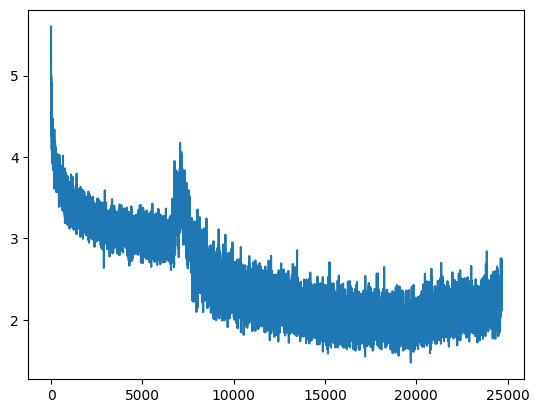

TRAIN TRUE: genre: ambient, newage; mood/theme: soft, relaxing

TRAIN PRED-HF: <|endoftext|>theme: relaxing<|endoftext|>

TRAIN PRED-OUR: motivational,theme, inspiring<|endoftext|>,theme: horror, insal, relaxing,otional documentary, 
inspirational, west<|endoftext|> lighttheme 2018 epic, advertising<|endoftext|><|endoftext|> language producer, 
energetic<|endoftext|><|endoftext|> ( happy, motivational<|endoftext|><|endoftext|> theme upbeat<|endoftext|> 
ast:theme<|endoftext|>, level, inspiring<|endoftext|> inspirational, lounge<|endoftext|>, thrj folk,

TEST TRUE: genre: hardcore, electronic, technoindustrial; mood/theme: powerful, dynamic

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: <|endoftext|><|endoftext|><|endoftext|>: summer<|endoftext|><|endoftext|> celebration, 
catchy<|endoftext|> arche upbeat relaxing: relaxing, 
sweetastic<|endoftext|>theme<|endoftext|><|endoftext|><|endoftext|>theme, sweet driving: horror, 
romance<|endoftext|>: theme: dark<|endoftext|> film, inspirational motivational<|endoftext|> driving 
tracks<|endoftext|>theme, a<|endoftext|><|endoftext|> warm:, inspiring, positive happy music, catchy sk 
motivational<|endoftext|>

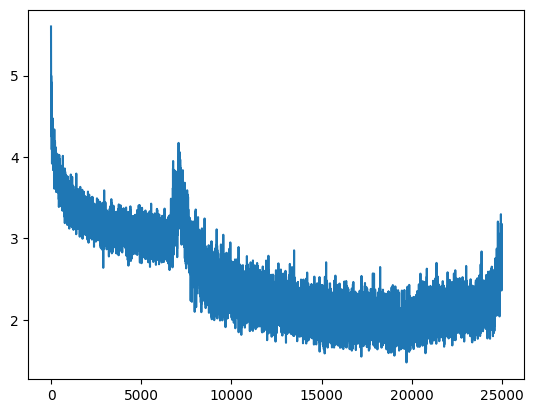

TRAIN TRUE: genre: techno, alternative, experimental, minimal, minimaltechno, electronic

TRAIN PRED-HF: <|endoftext|>, electronic; mood/theme: relaxing<|endoftext|>

TRAIN PRED-OUR: , alt; instrument: trumpet, synthes, electric; mood/theme: corar<|endoftext|> upbeat, 
melua<|endoftext|> adventure<|endoftext|> folk<|endoftext|> melj, upbeat, folk, emotional, cinema<|endoftext|> 
soul<|endoftext|> meliftingodd lounge<|endoftext|> sunny, optimistic, trailer relaxing, epic, summer 
folk<|endoftext|> dark, 70 20 commercial, calming

TEST TRUE: genre: soundtrack, orchestral; instrument: strings, brass; mood/theme: adventure, heroic, epic

TEST PRED-HF: <|endoftext|>, piano, relaxing; mood/theme: melitative<|endoftext|>

TEST PRED-OUR: <|endoftext|> drum<|endoftext|> upbeat<|endoftext|>,aline, audio<|endoftext|><|endoftext|> 
machine<|endoftext|> emotional/ sweetmond narrator, political meluss, vib track<|endoftext|> dance, 
classical<|endoftext|>ophone, energetic<|endoftext|> taware<|endoftext|> upbeat,theme/ musical<|endoftext|> 
film<|endoftext|> hopefulamb t subdued, lounge, upl – compassionate, relaxingem, upbeat, dramagae

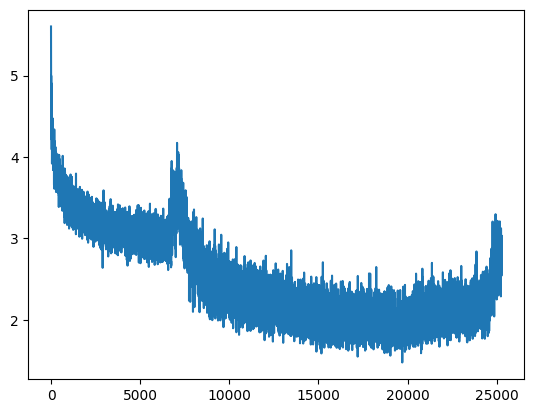

TRAIN TRUE: genre: dance, trance

TRAIN PRED-HF: <|endoftext|> electronic; mood/themethemethemethemethemethemethemetheme/themetheme/theme/themetheme/
relaxing<|endoftext|>

TRAIN PRED-OUR: instrumentalpop; instrument: soundtrack, house, music: synthespuitane, synthes<|endoftext|> guitar;
synthim, guitar<|endoftext|> drum, electricizer, midnightbone, guitar<|endoftext|> drums; 
mood/themethemethemeasia<|endoftext|> emotionalodicodic<|endoftext|> romantic<|endoftext|> 
loungeovythemetheme/themetheme/theme/themetheme/theme

TEST TRUE: genre: soundtrack, classical, easylistening; instrument: piano

TEST PRED-HF: <|endoftext|> piano: pianoening; 
mood/theme/theme/themethemethemetheme/theme/theme/theme/theme/theme/theme/theme/theme/theme/theme/ 
upbeat<|endoftext|>

TEST PRED-OUR: tberman; mood/theme/themethemetheme/themethemethemethemetheme/theme/theme/theme/theme/theme/theme/ 
short<|endoftext|>theme/theme/ fun ; mood/ positive, 
touringruggedovyeningtheme/themetheme/theme/theme/theme/themetheme/theme/theme/theme

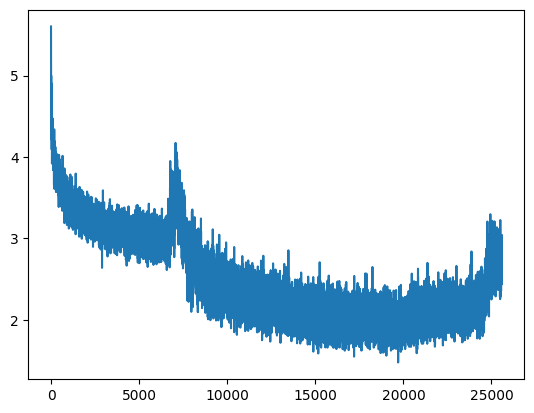

TRAIN TRUE: genre: downtempo, industrial, triphop, electronic, rock

TRAIN PRED-HF: <|endoftext|>, electronic; instrument: synthesizer, drumsizer, electricizer, synthesizer; 
mood/themethemetheme: dream<|endoftext|>

TRAIN PRED-OUR: : sound; moodtheme<|endoftext|><|endoftext|><|endoftext|><|endoftext|>theme<|endoftext|>theme: 
plane<|endoftext|>, fast<|endoftext|>themethemetheme: sound, 
inspirational<|endoftext|>themethemethemebeat<|endoftext|>themethemethemethemethemethemethemethemethemethemethemeth
emethemethemethemethemethemethemethemethemethemethemethemethemethemethemethemethemethemethemethemethemetheme

TEST TRUE: genre: classical; instrument: piano, cello

TEST PRED-HF: <|endoftext|> piano, piano, piano, synthesizer, piano, piano, piano; mood/theme: piano<|endoftext|>

TEST PRED-OUR: piano<|endoftext|> double piano; piano, fut, electric, piano; moodthemeld, piano, heavy: 
kitsizerogtheme: peacefulhi<|endoftext|> piano<|endoftext|> padop<|endoftext|> dartopthemeims, 
synthesizer<|endoftext|> renaissance: easypo acoustic<|endoftext|> ho electronic<|endoftext|> cab<|endoftext|> 
keyboard: pianoel, electric<|endoftext|> violin<|endoftext|>

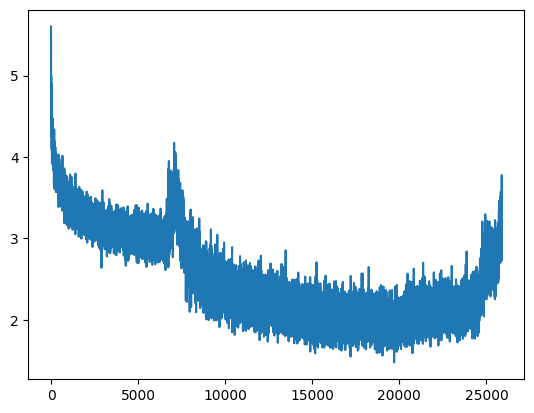

TRAIN TRUE: genre: ambient

TRAIN PRED-HF: <|endoftext|>, ambient; instrument: synthesizerizer: mood/theme: dream, mood/theme: dream, 
mood/theme: relaxing<|endoftext|>

TRAIN PRED-OUR: ; instrument: alternative, synthesizer; mood/theme: movie, mood/theme: happy, 
loop<|endoftext|>theme: happy, mood/theme: movie, holiday, moodtheme: relaxing<|endoftext|><|endoftext|> 
mood/theme: interactive mood/theme: ambient, mood/theme: ambient, mood/theme: relaxing, mood

TEST TRUE: genre: electronic, metal, technoindustrial; instrument: guitar, synthesizer

TEST PRED-HF: <|endoftext|> mood/theme: mood/theme: dream<|endoftext|>

TEST PRED-OUR: guitar, racizer, organpgpler; synthesizerizer, bassizer<|endoftext|> mood/theme: filledmbathy, 
mood/theme: progressive, ambient<|endoftext|> fulfilling mood/theme: inspirational, dream, moottheme: summer, 
dream,, natural<|endoftext|> mood/theme: sound, ambient<|endoftext|> cinematic, beginning

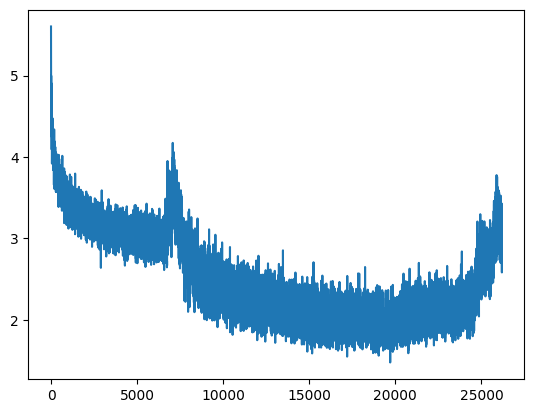

TRAIN TRUE: genre: electronic, latino, latin; mood/theme: urban

TRAIN PRED-HF: 
<|endoftext|>theme/theme/theme/theme:theme/theme/theme/theme/theme/theme/theme:theme/theme/theme:theme/theme/theme/
theme/theme/theme:theme:theme/theme/theme/theme/theme/theme/theme/theme:theme:theme:theme

TRAIN PRED-OUR: interesting<|endoftext|> timtheme: mel beatsua,theme: motivational, relaxing, 
traditional<|endoftext|> metal; shell, upbeat/theme/theme/theme: planetheme: narr/theme: energetic, 
meltheme/theme/theme:theme:theme/theme:theme:theme:theme:theme:theme:theme:theme

TEST TRUE: genre: alternative, experimental, electronic

TEST PRED-HF: <|endoftext|>; instrument: guitar, piano, 
acousticguituituituituituituituituituituituituituituituituituituituituituituituituituituituituituituituituituituitu
ituituituituituituituituituituituituituituituituituituit

TEST PRED-OUR: , poplistening; new: chamber: easy, drum: acoustic, way; guitar, guitar<|endoftext|><|endoftext|>, 
gtheme; organ, guitar<|endoftext|>machine: guitar, acousticg loop, guitar, drumbell, mood/theme: alterntheme: 
heavy, guitar<|endoftext|>, space<|endoftext|>, psychedelicitative/ soultheme:

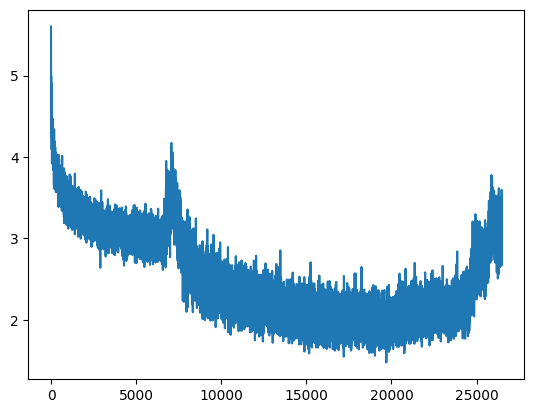

TRAIN TRUE: genre: disco, club, electronic

TRAIN PRED-HF: <|endoftext|> jazz; electronic, instrument: piano, guitar, piano, piano, piano, piano<|endoftext|>

TRAIN PRED-OUR: progressive<|endoftext|> horror<|endoftext|> jazz, hip<|endoftext|> jazz; electronicl piano, poprap
bass; ensemble drums, noise; with dance hip<|endoftext|><|endoftext|> electronic, renaissance<|endoftext|> guitar; 
techno,,, relaxing hip,,,, choir, piano music jazz guitar; house, dance, easy contrasted, instrumental naturalh, 
soundtrack;

TEST TRUE: genre: garage, electronic, breakbeat; instrument: bass

TEST PRED-HF: <|endoftext|> piano<|endoftext|>

TEST PRED-OUR: piano<|endoftext|> vocal drum; relaxing motivational, violin<|endoftext|>, guitar, sax, relaxing b 
electricu, pop<|endoftext|> percussion<|endoftext|> sho computer, piano percussion organ piano piano<|endoftext|> 
percussion piano organ rock drum; drumsron, relaxing rock, piano piano piano piano metal electric bell pop g 
electronic/: electronic electronic bell keyboard<|endoftext|> electronic drum

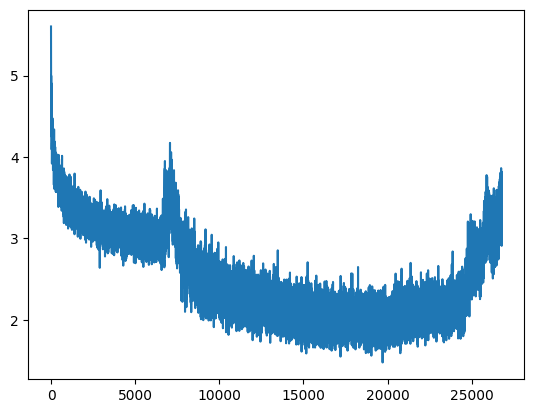

Unfroze gpt2


  0%|          | 0/6731 [00:00<?, ?it/s]

TRAIN TRUE: genre: easylistening, ambient, chillout, lounge; mood/theme: dream

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: <|endoftext|> rocking<|endoftext|> interesting, cinematic instrumental drama<|endoftext|> progress,
relaxing<|endoftext|><|endoftext|>, sktheme/ inspirational energetic<|endoftext|> ast, holiday horrortheme: 
psychedelic, love strings electric sktheme<|endoftext|> relaxing entertainmenttheme<|endoftext|> corporate 
inspirationtheme<|endoftext|> cabin mindless technical<|endoftext|> love country; soul montthemetheme narrative 
lounge<|endoftext|> intro dramatic especially western<|endoftext|> sad patriotic

TEST TRUE: genre: groove, funk, pop; mood/theme: happy, positive, inspiring

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: music piano<|endoftext|> hip<|endoftext|> animation<|endoftext|> computer percussion<|endoftext|>: 
sound theatre<|endoftext|> indie<|endoftext|> bar, relaxing politicalban sci trailer classical, animation electric 
structured<|endoftext|> folk sad mainland sad house gospel upbeat indie hip stories soft metal; pltheme, keyboard 
house<|endoftext|>theme animaltheme<|endoftext|> peaceful<|endoftext|> tradition moments, amb up sk boy, 
studio<|endoftext|>

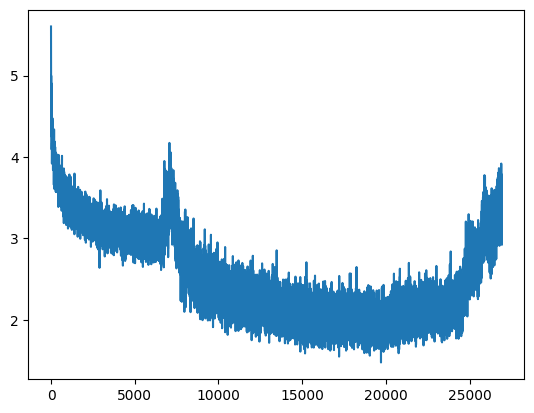

In [ ]:
for epoch in tqdm(range(num_epochs)):
    
    if epoch >= 1:
        print('Unfroze gpt2')
        for pg in opt.param_groups[1:]:
            pg['lr'] = 5e-5
    
    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        # tokenize and prepare inputs for forward
        input_ids, input_ids_target = tokenize(caption_batch)
        inputs_embeds, input_ids_target = transform_input_ids(
            embedding_batch,
            input_ids,
            input_ids_target
        )
        
        losses.append(update_step(inputs_embeds, input_ids_target))
        
        if step % 300 == 0:
            eval_step()
            plt.plot(losses)
            plt.show()

In [ ]:
caption_batch, embedding_batch = next(iter(eval_test_dataloader))
pred = eval(caption_batch, embedding_batch, use_manual_generation=True)
printr('[green bold]TEST TRUE: ' + caption_batch[0])
printr('[blue]TEST PRED-A: ' + pred[0])